# Math Lectures
### Unit 4 Capstone (Thinkful Data Science)
In this note book we will use common techniques in Natural Language Processing to tokenize the closed captioning of 93 lectures aquired as XML files from the internet.
Project Outline:
 - Process the XML into text (removing html tags)
 - Vectorize each sentence using tf idf and Doc2Vec
 - Calculate the cosine similarity of sentences
 - Use KMeans clustering to cluster the sentences
 - Reduce the dimensionality using t-SNE and PCA
 - Visualize the results
 - Examine the text of the cluster assignments
 - Examine frequency of word use and subject professor density of each cluster
 - Use NMF (non-negative matrix factorization) to extract topics
 - Building a supervised model to predict the subject/professor of the sentence.
 - Compare the results of the two classification methods


In [409]:
import os
import time
from collections import Counter, OrderedDict
from itertools import islice
import smart_open

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, ensemble, linear_model, naive_bayes, neighbors, svm
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit


from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')
warnings.filterwarnings("ignore",category=DeprecationWarning)


default_stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
sns.set(style='dark',context='paper',palette='mako')
%matplotlib inline


 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [6]:
glob_time1 = time.time()

### Importing the data
    - The texts consist of the closed captioning for 93 lectures on varying topics in mathematics, computer science, and engineering
    - The XML files were accessed through the console in a web browser and saved as XML 

In [7]:
#set path to XML files
path = '/root/Desktop/gits/unit-4-NLP-capstone/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([re.sub('.xml','',os.fsdecode(file)) for file in os.listdir(folder)])
#filenames = [ re.sub('.xml','',i) for i in filenames ]

#Use ElementTree trace xml tree and extract text from xml files, removing tags
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}.xml'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)

In [8]:
#check some text from a random lecture
lecture_texts[47][30:35]

['the most common change of\nvariables is the one simple one',
 'called scaling.\nSo, again, the kind of equation',
 "I'm talking about is a general\nfirst-order equation.",
 'And, scaling simply means to\nchange the coordinates,',
 'in effect, or axes,\nto change the coordinates on']

In [9]:
#create a DataFrame for records
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = [ ' '.join(i) for i in lecture_texts ] #unpack list of lists as string
print(type(raw_data.raw_text[0]))
raw_data.head(1)

<class 'str'>


filename                                           raw_text
0  aurouxmcalc1  So let's start right away with\nstuff that we ...

### Cleaning the text

Now we will clean the text removing '\n', the intros (MIT has a long intro), the professor names and other undesirable punctuation etc. Also, we want to replace contractions with thier full counterparts.

In [10]:
#Function to remove identified words through visual inspection
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. ",'',text)
    text = re.sub('Your support will help MIT OpenCourseWare continue to',' ',text)
    text = re.sub(' offer high quality educational resources for free.',' ',text)
    text = re.sub('To make a donation or ',' ',text)
    text = re.sub('view additional materials from hundreds of MIT',' ',text)   
    text = re.sub(' courses, visit MIT OpenCourseWare at ocw.mit.edu.',' ',text)   
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    text = re.sub('Welcome to 6.851 Advanced Data Structures', 'PROFESSOR',text)
    text = re.sub('PROFESSOR: PROFESSOR', ' ',text)
    text = re.sub('PROFESSOR PROFESSOR', ' ',text)
    return text

#list common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


In [11]:
raw_data.raw_text = [ expand_contractions(i) for i in raw_data.raw_text]
raw_data.raw_text = [ text_cleaner(i) for i in raw_data.raw_text]

In [12]:
#label professors
raw_data['Professor'] = ['Auroux']*4 + ['Demaine']*7 + ['Devadas']*9 + ['Jerison']*9 + ['Leighton']*11 + ['Manning']*3 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*18 + ['Winston']* 8
#label_subjects
raw_data['Subject'] = ['Calculus']*4 + ['Data']*7 + ['Algorithms']*9 + ['Calculus']*9 + ['CS Math']*11 + ['NLP']*3\
+ ['Differential Equations']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 8 +\
['AI']*8
raw_data.head(1)

filename                                           raw_text Professor  \
0  aurouxmcalc1  So let us start right away with stuff that we ...    Auroux   

    Subject  
0  Calculus

### Tokenization with spacy

Here we will parse the text using spacy and append each spacy object (each lecture) to the dataframe.
Then we will create a new data frame with the professor, subject, filename and the spacy doc.
We will use a list comprehension to tokenize each sentences from each lecture and append the list of lists to the dataframe.
Then we will drop the spacy doc, we will -explode- the data frame so that each sentence is an observation, while maintaining tracability to the lecture level.
We will also take the sentence length for further sentence elimination.

In [13]:
#Create Spacy document for each lecture
t1 = time.time()
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]
print('Minutes: {}'.format((time.time()-t1)/60))

Minutes: 4.54169450600942


In [14]:
#create a new data frame for the professor,subject and the spacy doc
sentences = raw_data[['filename','Professor','Subject','sdoc']].copy()

#create a list of lists of tokens (remove stop words and punct) 
sentences['sents'] = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in sentences.sdoc]

#explode the df to a new df with each sentence on one line
sentences1 = pd.DataFrame({
         col:np.repeat(sentences[col].values, sentences['sents'].str.len())
         for col in sentences.columns.difference(['sents'])
         }).assign(**{'sents':np.concatenate(sentences['sents'].values)})[sentences.columns.tolist()]

#get sentence lengths
sentences1['s_len'] = [len(sent) for sent in sentences1.sents]

In [15]:
#check to make sure distribution of attributes to sentences
sentences1.sample(5,random_state=43)

filename Professor     Subject  \
59242         strangmeng5    Strang   Mech. Eng   
11965       devadasalgos3   Devadas  Algorithms   
5335        demainedata15   Demaine        Data   
57511         strangmeng2    Strang   Mech. Eng   
23516  leighton15linearcs  Leighton     CS Math   

                                                    sdoc  \
59242  (   , To, make, a, donation, ,, or, to,    , P...   
11965  (       , PROFESSOR, :, So, today, 's, lecture...   
5335   (       , PROFESSOR, :, All, right, ., Today, ...   
57511  (Your, support, will, help, MIT, OpenCourseWar...   
23516  (  , offer, high, -, quality, educational, res...   

                                                   sents  s_len  
59242                      [-pron-, be, get, zero, will]      5  
11965  [the, reason, interested, algorithm, people, w...      7  
5335                     [but, general, small, power, 2]      5  
57511                   [so, be, differential, equation]      4  
23516                                        [professor]      1

In [16]:
sentences1.shape

(65569, 6)

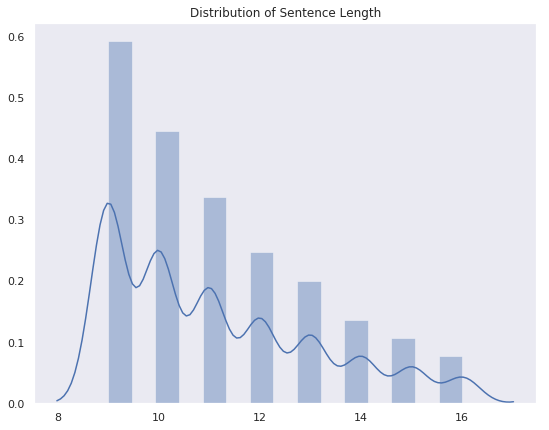

count    10156.000000
mean        11.111166
std          2.014851
min          9.000000
25%          9.000000
50%         11.000000
75%         12.000000
max         16.000000
Name: s_len, dtype: float64

In [400]:
plt.figure(figsize=(9,7))
sns.distplot(tuple(sentences1.s_len),bins=15)
plt.title('Distribution of Sentence Length')
plt.show()

sentences1.s_len.describe()

In [18]:
sentences1.shape

(65569, 6)

Currently we have 65000+ sentences that need to be vectorized and processed. In order to avoid complications with the vectorization and clustering, I will set a minimum word length for each sentence.
    
    - Create a list of index numbers to keep
    - Replace the dataframe with only desired index numbers
    - Convert lists of tokens to strings
    - Remove '-pron-' token created by spacy
We've set a window of 9 to 16 sentence size. This will reduce the number of sentences to around 10,000, while hopefully still preserving the substance of the texts.  This is really a compromise. Vectorizing and processing 66,000 sentences is computationally and time intensive, so we want the reduction. Plus, I don't want the model to think sentences like "That's Right" or "Now, what?" or any other short meaningless statement you would hear in a math lecture are more important than longer sentences describing a concept.

In [19]:
#list index numbers to keep
to_keep = [ i for i in sentences1.index if len(sentences1.sents[i]) >= 9 and len(sentences1.sents[i]) <= 16]
#keep index numbers,execute other steps
sentences1 = sentences1.iloc[to_keep]
sentences1['text'] = [' '.join(i) for i in list(sentences1.sents)]
sentences1.text = [ re.sub("-pron-","",sentences1.text[i]) for i in to_keep]
sentences1.reset_index(inplace=True, drop=True) #reset the index here
sentences1.sample(5, random_state=43)

filename Professor     Subject  \
3177  leighton14dandcs  Leighton     CS Math   
6641   rigolletstats19  Rigollet  Statistics   
9408       strangmeng6    Strang   Mech. Eng   
7650       sochernlp13    Socher         NLP   
2590     jerisoncalc21   Jerison    Calculus   

                                                   sdoc  \
3177  (       , PROFESSOR, :, This, week, we, are, g...   
6641  (    , to,    , PROFESSOR, :, ,, bunch, of, x,...   
9408  (   , To, make, a, donation, ,, or, to,    , P...   
7650  ( , Network, ,, there, is, actually, a, whole,...   
2590  (   , To, make, a, donation, ,, or, to,    , P...   

                                                  sents  s_len  \
3177  [all, right, like, know, long, till, world, en...      9   
6641  [think, realization, guy, go, cloud, n, point,...      9   
9408  [so, -pron-, want, sum, square, -pron-, think,...      9   
7650  [well, model, go, see, small, norm, feature, v...     11   
2590  [and, -pron-, think, order, answer, question, ...     12   

                                                   text  
3177        all right like know long till world end t64  
6641        think realization guy go cloud n point r d.  
9408     so  want sum square  think cos(theta sin(theta  
7650  well model go see small norm feature vector z ...  
2590  and  think order answer question  go detail me...

In [20]:
sentences1.shape

(10156, 7)

### Split the data 
 - We need to split the data for training and testing purposes, we will set X as the sentences and Y as the labels to maintain traceability

In [21]:
#Split the data into train and test set.
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

### Tf-Idf Vectorization of the sentences
    Right now we are going to create numerical vectors for each sentence using the Tf-idf feature from the genism library.

In [22]:
#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 15
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True 
                            )

In [23]:
#Fit vectorizer and transform X_train to vectors
X_train_tfidf = vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_train_tfidf_csr = X_train_tfidf.tocsr() #Reshapes the vectorizer output into something people can read
n = X_train_tfidf_csr.shape[0] #number of sentences
tfidf_bysent = [{} for _ in range(0,n)] #A list of dictionaries, one per sentence
terms = vectorizer.get_feature_names() #List of features
#for each sent, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]
print('Original sentence:', X_train[4421],y_train[4421])
print('Tf_idf vector:', tfidf_bysent[4421])

Number of features: 453
Original sentence: after find eigenvalue lambda omega squared know omegas find eigenvector ['Strang' 'Mech. Eng' 'strangmeng10']
Tf_idf vector: {'know': 0.3611194426533281, 'omega': 0.5501703808312975, 'squared': 0.5194008067903516, 'lambda': 0.5450945808749401}


### Calculating the cosine similarity of each sentence 

from wiki:
   " Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0,π] radians. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors oriented at 90° relative to each other have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. "
https://en.wikipedia.org/wiki/Cosine_similarity

We will use this metric to asses similarity of sentences.

In [24]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
df_similarity = pd.DataFrame(cosine_similarity(X_train_tfidf), index=range(len(X_train)),
                            columns=X_train) # set sentneces as the columns


In [25]:
df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

In [26]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [27]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
1672                                           0.709474                         
5563                                           0.702142                         
6827                                           0.686053                         
6662                                           0.649410                         

                                      Original_Sentence Professor  \
4421  after find eigenvalue lambda omega squared kno...    Strang   
1672  and denominator omega nought squared minus ome...   Mattuck   
5563  ay = lambda*y multiply a. a squared*y lambda*a...    Strang   
6827  omega square root omega nought squared minus p...   Mattuck   
6662     omega d omega square plus omega nought squared   Mattuck   

                     Subject       filenames  mean_similarity  
4421               Mech. Eng    strangmeng10         0.013513  
1672  Differential Equations  mattuckdifeq10         0.013710  
5563               Mech. Eng     strangmeng6         0.006807  
6827  Differential Equations  mattuckdifeq10         0.015854  
6662  Differential Equations  mattuckdifeq10         0.012165

### Use PCA to reduce dimensionality and visualize results

In [28]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(X_train_tfidf.todense())

pca_kclusters = pd.DataFrame()
pca_kclusters['original'] = X_train
pca_kclusters['Professor'] = y_train[:,0]
pca_kclusters['Subject'] = y_train[:,1]
pca_kclusters['PCA_1'] = Y[:,0]
pca_kclusters['PCA_2'] = Y[:,1]
pca_kclusters['filename'] = y_train[:,2]
df_similarity['PCA_1'] = Y[:,0]
df_similarity['PCA_2'] = Y[:,1]

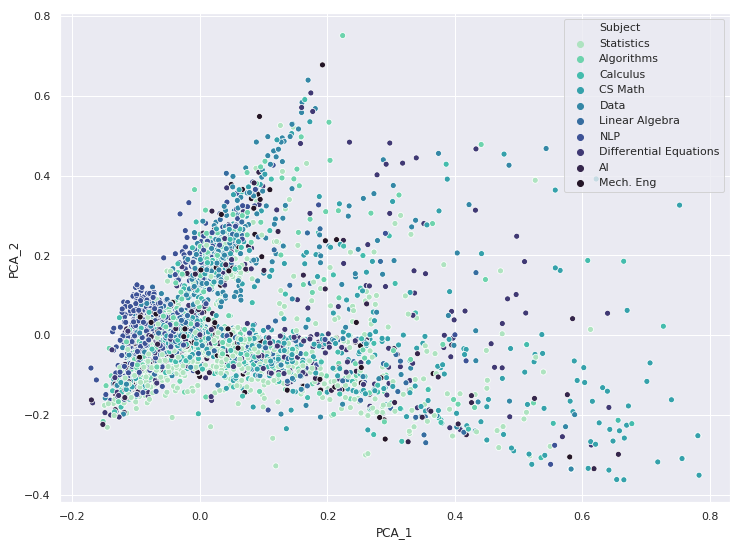

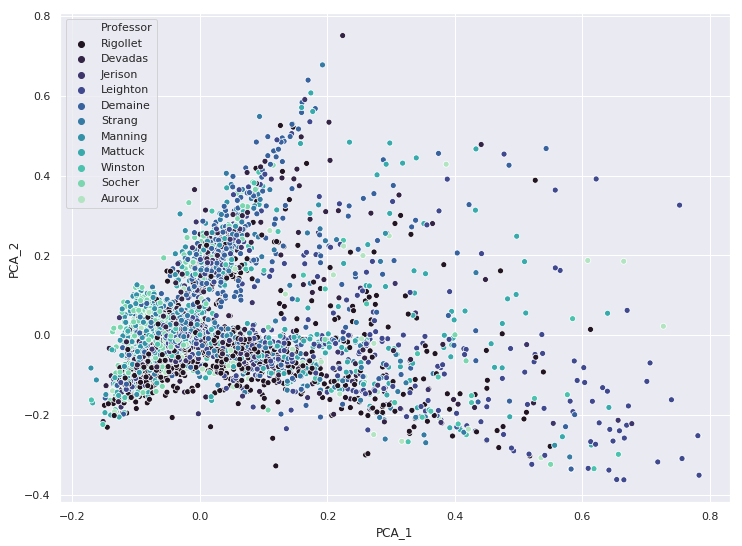

In [29]:
sns.set_context('notebook')
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Subject',data=pca_kclusters,palette='mako_r')
plt.show()
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Professor',data=pca_kclusters,palette='mako')
plt.show()

Now that the dimension has been reduced to two, we can scatter the results and color the cluster label, for a given number of clusters.
I chose the folowing as the number of clusters to test [5, 6, 7, 8, 9, 10, 11, 25, 93]. 
10,11,93 because it is the number of professors,subjects,lectures respectively.
For good measure I try 5 (lower than the desired cluster amount) and 25 (higher than the desired number).


The desired number of clusters is based on number of subjects and number of professors. >> 10 or 11

### KMeans Clustering

We will iterate over the list of cluster numbers, clustering and plotting the two PCA components with the correst cluster assignment as the hue of each point.

Number of Clusters: 5

Silhouette avg 5 clusters: 0.4663107503482564




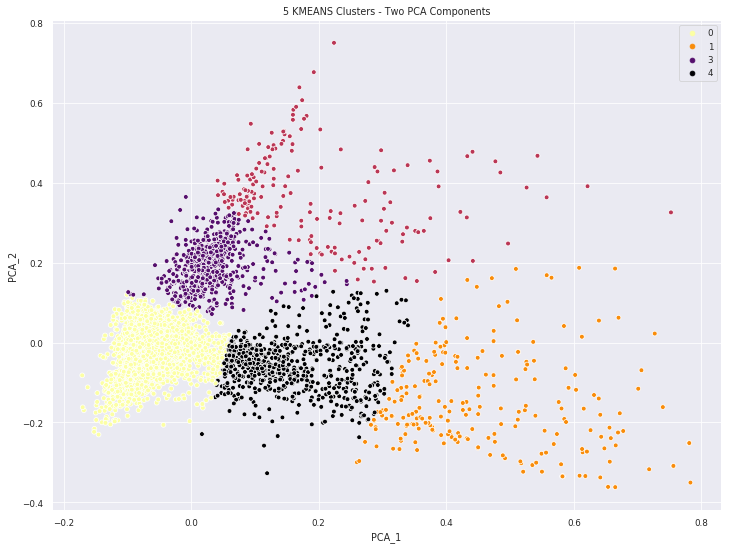

Number of observations per cluster:
0    5854
4     696
3     633
1     252
2     182
dtype: int64
Time: 2.9053549766540527 seconds.

Number of Clusters: 6

Silhouette avg 6 clusters: 0.050055661898883254




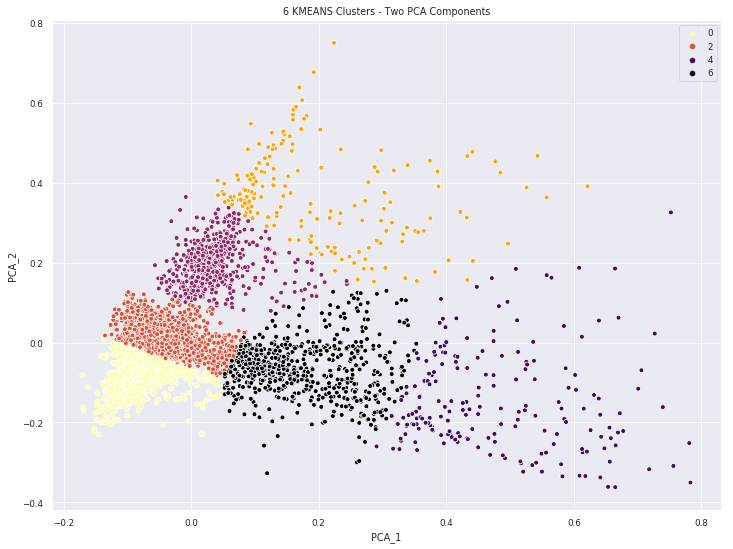

Number of observations per cluster:
2    4234
0    1699
5     666
3     617
4     221
1     180
dtype: int64
Time: 2.1173081398010254 seconds.

Number of Clusters: 7

Silhouette avg 7 clusters: 0.07170651601898256




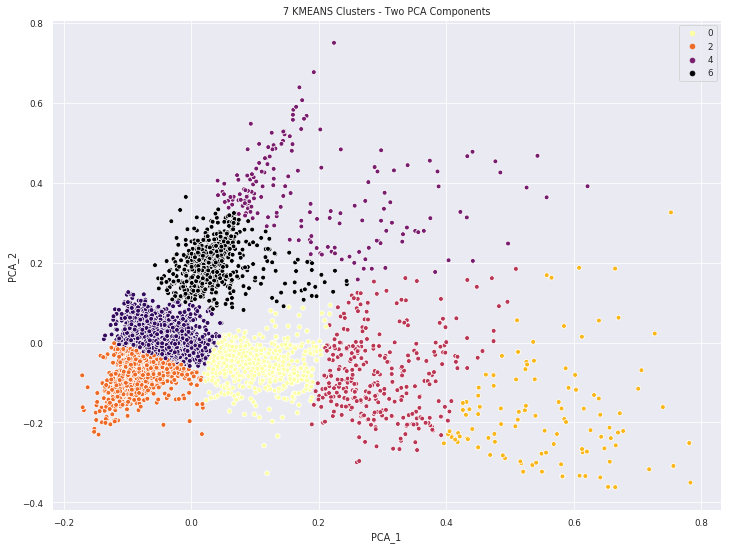

Number of observations per cluster:
5    4172
2    1621
6     618
0     577
3     319
4     177
1     133
dtype: int64
Time: 2.299100875854492 seconds.

Number of Clusters: 8

Silhouette avg 8 clusters: 0.03579325399978595




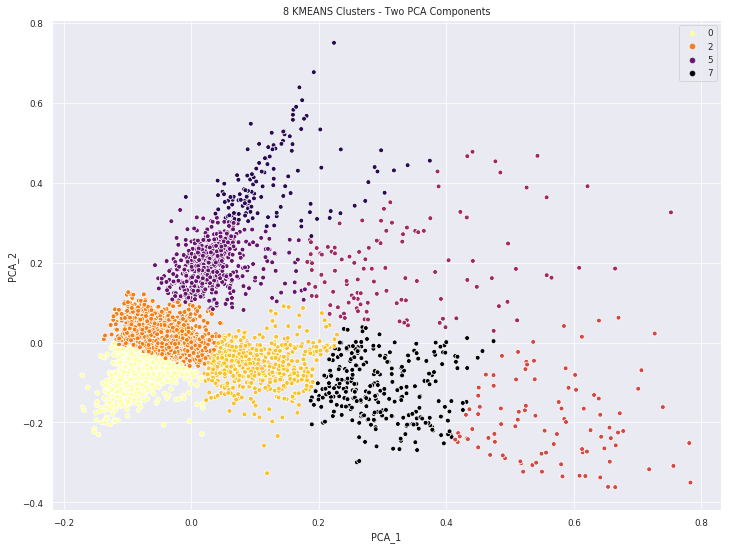

Number of observations per cluster:
2    4172
0    1621
5     594
1     581
7     279
6     133
3     119
4     118
dtype: int64
Time: 2.2818944454193115 seconds.

Number of Clusters: 9

Silhouette avg 9 clusters: -0.01888880993837617




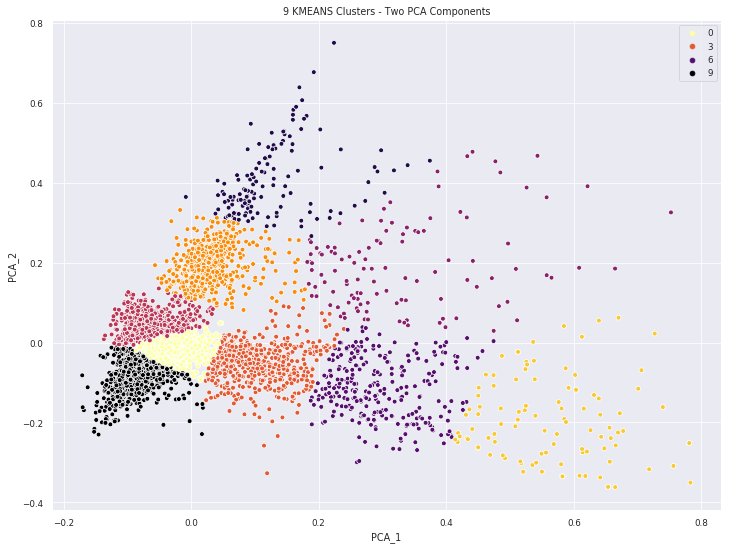

Number of observations per cluster:
0    3438
8    1349
4    1036
2     577
3     570
6     278
7     133
1     119
5     117
dtype: int64
Time: 2.23209285736084 seconds.

Number of Clusters: 10

Silhouette avg 10 clusters: -0.033888359335925676




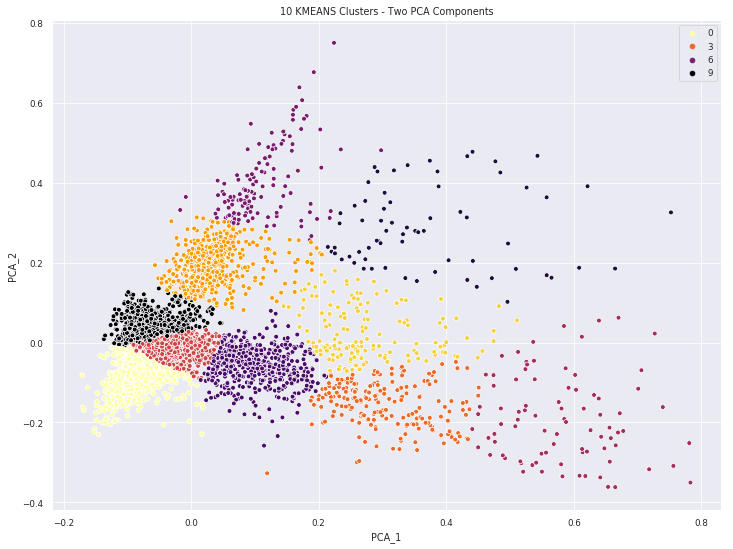

Number of observations per cluster:
4    3459
0    1329
9    1032
2     577
7     546
3     209
1     157
6     130
5     108
8      70
dtype: int64
Time: 2.2277166843414307 seconds.

Number of Clusters: 11

Silhouette avg 11 clusters: -0.12538510696382962




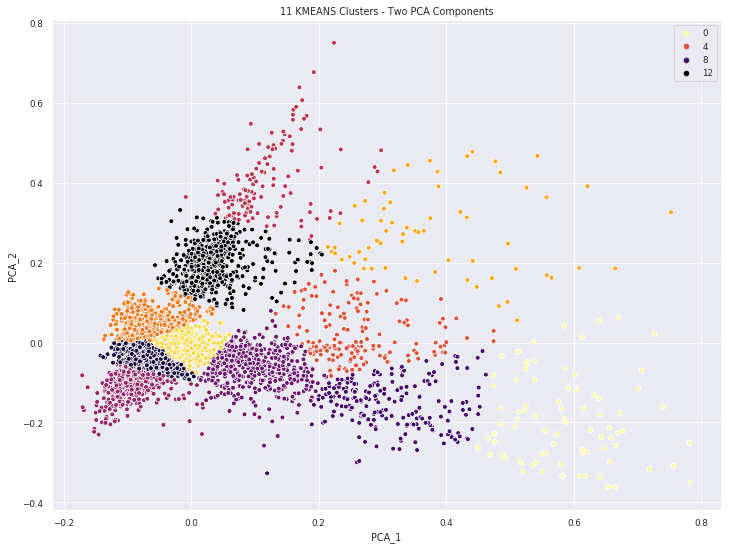

Number of observations per cluster:
1     2507
9     1958
3      839
10     577
6      534
7      525
8      213
4      164
5      128
0      104
2       68
dtype: int64
Time: 2.272571325302124 seconds.

Number of Clusters: 25

Silhouette avg 25 clusters: -0.244478796721709




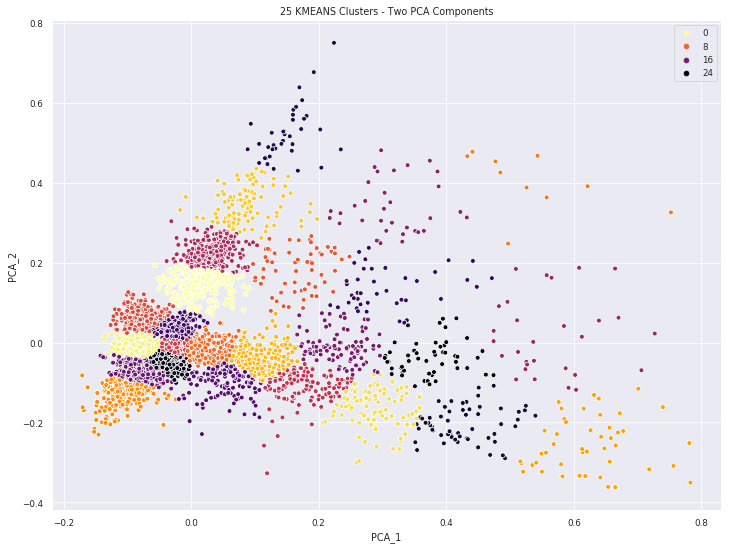

Number of observations per cluster:
11    1666
23     974
1      953
19     693
17     688
8      320
10     307
13     290
0      265
4      250
6      242
12     141
dtype: int64
Time: 2.7820968627929688 seconds.

Number of Clusters: 93

Silhouette avg 93 clusters: -0.4659664990505823




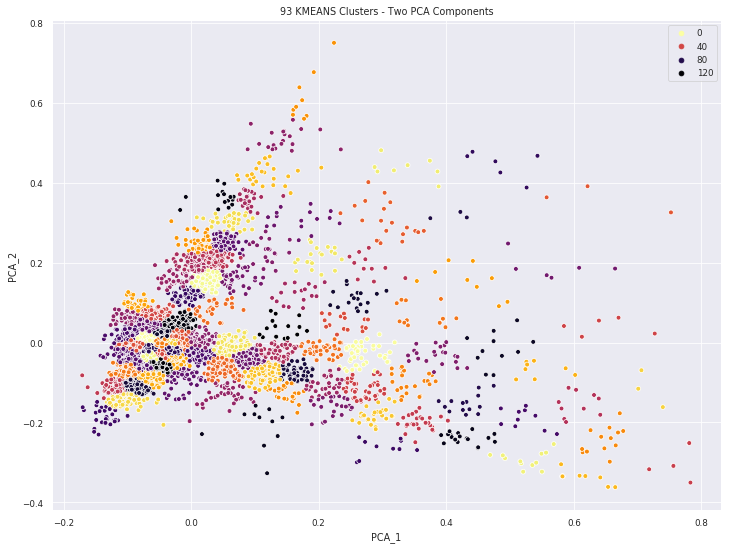

Number of observations per cluster:
11    479
26    477
78    423
39    383
32    336
3     313
79    298
85    273
70    270
91    252
36    236
18    217
dtype: int64
Time: 5.512378215789795 seconds.



In [30]:
sns.set_context('paper')
k_clusters = [5,6,7,8,9,10,11,25,93]
for i in k_clusters:
    t1 = time.time()
    modelk_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette avg {} clusters:'.format(i), silhouette_score(Y, modelk_clusters, metric='cosine'))
    print('\n')
    pca_kclusters['cluster_k='+str(i)] = modelk_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue=modelk_clusters, data=pca_kclusters,palette='inferno_r')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} KMEANS Clusters - Two PCA Components".format(i))   
    plt.show()    
    print('Number of observations per cluster:')
    print(pd.value_counts(modelk_clusters)[:12])
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

In [ ]:
Visualize the text of a random cluster

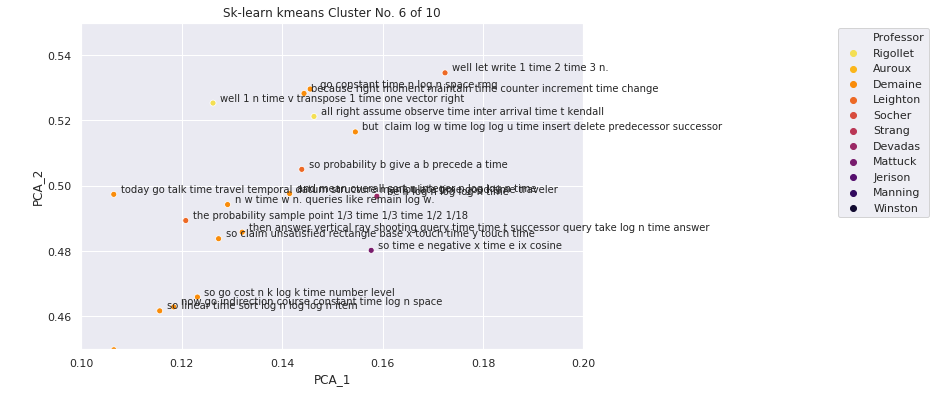

In [31]:
cluster6 = pca_kclusters[pca_kclusters['cluster_k=10'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_kclusters[pca_kclusters['cluster_k=10'] == 6],
                palette='inferno_r')
for label, x, y in zip(cluster6.original,cluster6.PCA_1,cluster6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

plt.xlim(.1,.2)
plt.ylim(.45,.55)
plt.title('Sk-learn kmeans Cluster No. 7 of 10')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()    


So far its hard to tell what the algorithm is doing. The silhouette scores are pretty horrible. They range from .5 to -.47. A large loss in score occurs between 5 and 6 clusters. For this cluster at least almost every sentence contains the word 'time.'

### Vectorization of Sentences with Doc2Vec
Learn paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”.

The algorithms use either hierarchical softmax or negative sampling; see Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean: “Efficient Estimation of Word Representations in Vector Space, in Proceedings of Workshop at ICLR, 2013” and Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean: “Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013”.
https://radimrehurek.com/gensim/models/doc2vec.html

When training a Doc2Vec model, both word representations and paragraph representations are stored. Using the vector representation of each sentence in the model, we can then attempt to cluster the data again and compare the results with our tf-idf vectors. 

#### Important features of the Doc2Vec Class
    -Word2VecKeyedVectors – This object essentially contains the mapping between words and embeddings. After training, it can be used directly to query those embeddings in various ways.
    
    - Doc2VecKeyedVectors – This object contains the paragraph vectors. Remember that the only difference between this model and Word2Vec is that besides the word vectors we also include paragraph embeddings to capture the paragraph.

    In this way we can capture the difference between the same word used in a different context. For example we now have a different representation of the word “leaves” in the following two sentences

    1. Manos leaves the office every day at 18:00 to catch his train
    2. This season is called Fall, because leaves fall from the trees.

    In a plain Word2Vec model the word would have exactly the same representation in both sentences, in Doc2Vec it will not.


In [32]:
#Split the data exactly the way it was previously split
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [33]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [34]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [35]:
'''#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=100, # 100 dimensions should be fine for our corpus
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=7, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("math_lects2.model")
print("Model Saved")
print("Time: {}".format(t2-t1))'''

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [36]:
#load the saved model
model= Doc2Vec.load("math_lects2.model")

In [37]:
X_train.shape

(7617,)

In [38]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])
print(tagged_data[4421])
print(model.docvecs['4421'])

TaggedDocument(['after', 'find', 'eigenvalue', 'lambda', 'omega', 'squared', 'know', 'omegas', 'find', 'eigenvector'], ['4421'])
[ 1.2728446e+00  3.4422400e+00  3.2598712e-02  4.2461094e-01
 -7.8580344e-01  9.2627704e-01  4.1250423e-01 -1.1120907e+00
  4.7397023e-01  2.4435365e-01  2.8793287e-01 -1.4638776e+00
 -4.7965446e-01 -4.8024976e-01 -7.0061153e-01  1.1146189e+00
  1.3136872e+00  1.7012703e+00  2.9906127e-01  4.2717859e-01
 -5.7784784e-01 -3.5227820e-01  4.8567411e-01 -7.7499968e-01
  2.0417672e-01  3.4177810e-01  1.9500971e+00  1.2788541e+00
  3.8816601e-01 -7.5848138e-01 -9.3545243e-02 -2.6171798e-01
  1.3904992e+00  1.4267498e-01  1.6693540e+00  1.3218819e+00
  1.9264374e+00  3.3820164e-01 -9.2997760e-01 -2.4959950e+00
 -1.4931414e+00 -8.2523501e-01  2.1535767e-02 -1.6089793e-01
  3.7526530e-01  1.4018161e+00 -5.5778140e-01  3.8988107e-01
 -8.4110492e-01 -2.6553827e-03  2.4658056e-01 -1.6841555e-01
 -5.0418490e-01 -2.9320180e-01  1.3143194e-01  2.5414379e+00
 -1.5319964e+00  

In [39]:
vecs.shape

(7617, 100)

In [ ]:
### Calculate Similarity of sentences in the Doc2Vec model 

In [40]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
d2v_sim = pd.DataFrame(cosine_similarity(vecs), index=range(len(X_train)),
                            columns=X_train) # set sentneces for the rows and columns
#calculate the mean similarity of each sentence
d2v_sim.insert(0, 'mean_similarity', d2v_sim.mean(axis=1))

In [41]:
#add identification to similarity dataframe
d2v_sim['Professor'] = y_train[:,0]
d2v_sim['Subject'] = y_train[:,1]
d2v_sim['Original_Sentence'] = X_train
d2v_sim['filenames'] = y_train[:,2]

In [42]:
#check benchmark sentence
sentence = X_train[4421]
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
641                                            0.537138                         
549                                            0.536796                         
6607                                           0.510963                         
4808                                           0.509065                         

                                      Original_Sentence Professor     Subject  \
4421  after find eigenvalue lambda omega squared kno...    Strang   Mech. Eng   
641    kind search see find large element find small...   Devadas  Algorithms   
549      and course eig command matlab find y 's lambda    Strang   Mech. Eng   
6607  and eigenvector know large carry large varianc...  Rigollet  Statistics   
4808  so implicit differentiation technique allow di...   Jerison    Calculus   

            filenames  mean_similarity  
4421     strangmeng10         0.112888  
641     devadasalgos6         0.130273  
549       strangmeng6         0.161898  
6607  rigolletstats19         0.154353  
4808     jerisoncalc5         0.148722

We  can see that the similar sentences in the Doc2Vec model differ from those in the TFIDF similarity matrix.  A noticable difference is the TFIDF vectors tend to be more similary based on word frequency (as expected). In the first similarity comparison for sentence 4421, we can see that the most similar sentences are those with 'omega'. However in the Doc2Vec it appears to be incorporating multiple words. In the results directly above, we can see that the most similar sentences contains the word 'find' followed by other sentences that contain various words from the benchmark sentence (eigenvector and lambda)

#### Reduce dimensionality of Doc2Vec sentences with PCA and plot results

In [43]:
vecs.shape

(7617, 100)

In [44]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(vecs)

pca_d2vclusters = pd.DataFrame()
pca_d2vclusters['original'] = X_train
pca_d2vclusters['Professor'] = y_train[:,0]
pca_d2vclusters['Subject'] = y_train[:,1]
pca_d2vclusters['PCA_1'] = Y[:,0]
pca_d2vclusters['PCA_2'] = Y[:,1]
pca_d2vclusters['filename'] = y_train[:,2]

Number of Clusters: 5

Silhouette Score 5 clusters: 0.3167087481593331




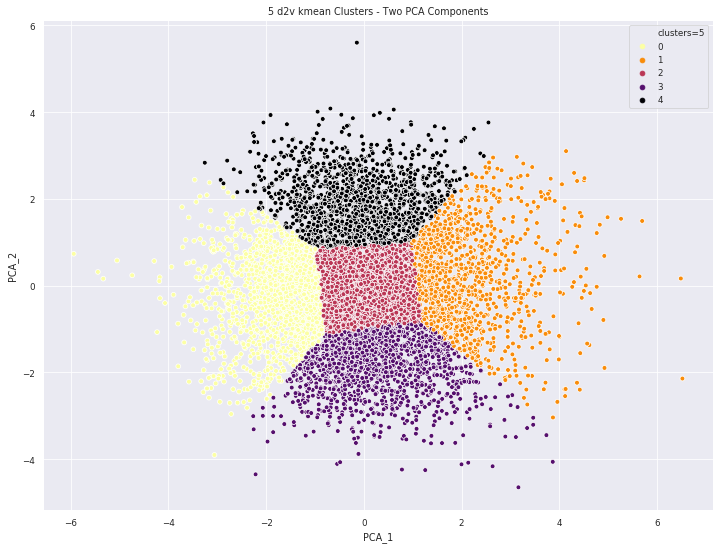


Avg Obs per cluster: 1523.4

Number of observations per cluster:
2    1896
0    1598
4    1522
3    1412
1    1189
dtype: int64
Time: 4.664540767669678 seconds.

Number of Clusters: 7

Silhouette Score 7 clusters: 0.2904988475665686




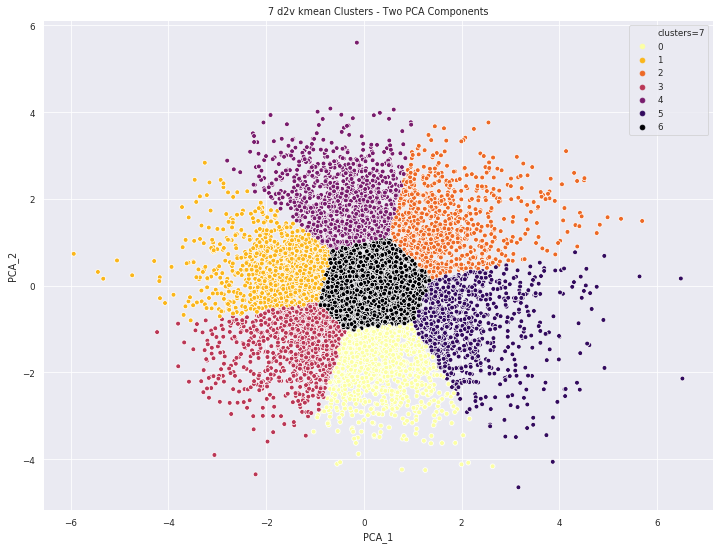


Avg Obs per cluster: 1088.142857142857

Number of observations per cluster:
6    1838
1    1147
4    1113
0     983
3     895
2     857
5     784
dtype: int64
Time: 2.7566051483154297 seconds.

Number of Clusters: 9

Silhouette Score 9 clusters: 0.13319725820042513




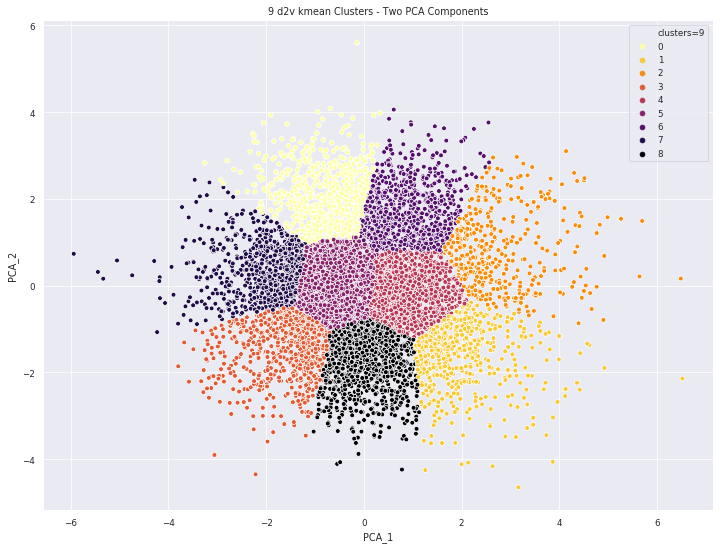


Avg Obs per cluster: 846.3333333333334

Number of observations per cluster:
5    1538
4    1107
8     988
6     859
0     778
7     732
3     658
1     537
2     420
dtype: int64
Time: 3.040466785430908 seconds.

Number of Clusters: 10

Silhouette Score 10 clusters: 0.06784929100411874




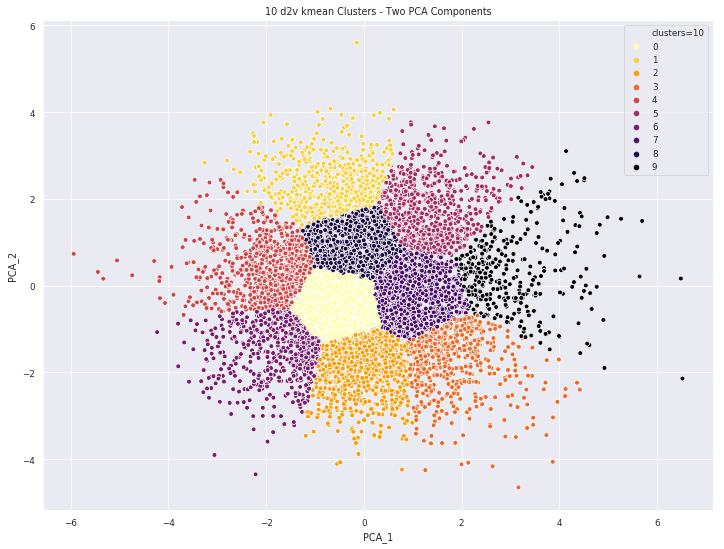


Avg Obs per cluster: 761.7

Number of observations per cluster:
0    1236
7    1037
8     941
2     847
4     840
5     686
1     631
6     554
3     505
9     340
dtype: int64
Time: 3.5668063163757324 seconds.

Number of Clusters: 11

Silhouette Score 11 clusters: 0.0004814066394579562




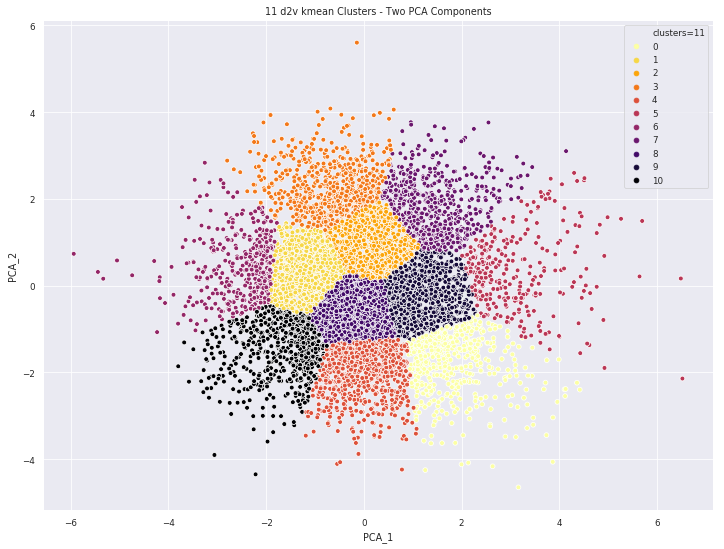


Avg Obs per cluster: 692.4545454545455

Number of observations per cluster:
8     1143
1      960
9      849
2      843
4      732
3      699
10     607
7      599
0      484
6      396
5      305
dtype: int64
Time: 3.2218098640441895 seconds.

Number of Clusters: 25

Silhouette Score 25 clusters: -0.2595161927303134




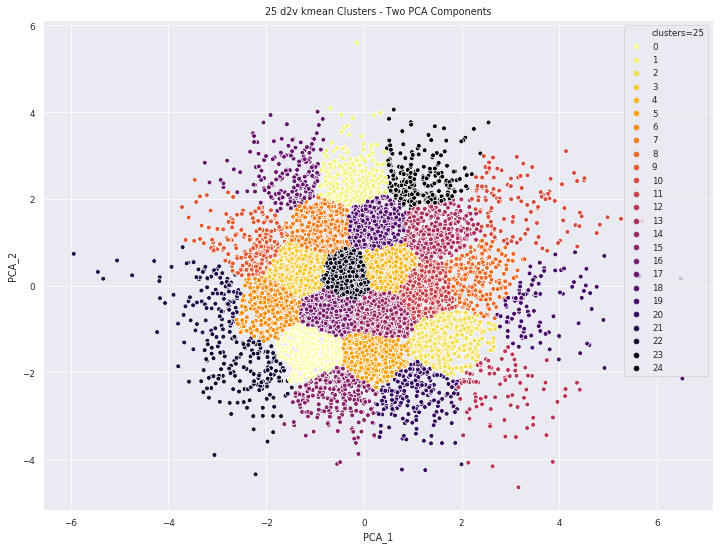


Avg Obs per cluster: 304.68

Number of observations per cluster:
14    538
23    531
16    530
3     477
5     425
18    418
11    396
4     386
7     372
2     357
13    339
0     330
dtype: int64
Time: 4.231027841567993 seconds.



In [99]:
sns.set_context('paper')
d2v_clusters = [5,7,9,10,11,25]
for i in d2v_clusters:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Y, d2v_clusters, metric='cosine'))
    print('\n')
    pca_d2vclusters['clusters='+str(i)] = d2v_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_d2vclusters,palette='inferno_r',legend='full')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_clusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

The two dimensional shape of the doc2vec vectors seems to have more symmetry than that of the TFIDF vectors.
Also another remark is the 5 ness of the clusters, they seem to be pentagonal.

Lets take a look at a cluster from one of the iterations and visualize the text.

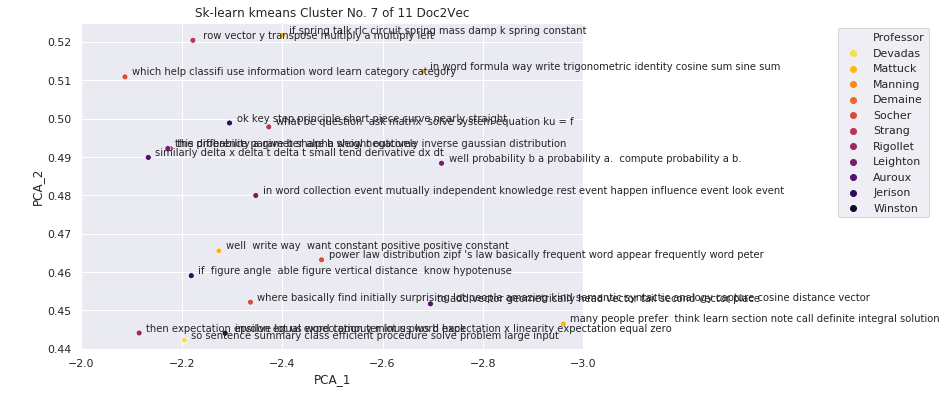

In [98]:
clusterd2v6 = pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6],
                palette='inferno_r')
for label, x, y in zip(clusterd2v6.original,clusterd2v6.PCA_1,clusterd2v6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

plt.xlim(-2,-3)
plt.ylim(.44,.525)
plt.title('Sk-learn kmeans Cluster No. 7 of 11 Doc2Vec')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

So  far we have seen the K means algorithm create clusters of different sizes for both TF-IDF vectorization and Doc2Vec vecotrization.

The results of the silhouette scores were not very good. Many of them were close to zero for my desired clusters (10 or 11).
According to the documentation for sklearn silhouette score:
"Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster."

One observation to be made at this point is that the clusters seem to contain sentences that just have similar word use(see above).
How ever the clusters do not seem to line up directly with the similarity scores.
See below for an example.

In [47]:
#display sentences from referenced lecture
d2v_sim['cluster11'] = pca_d2vclusters['clusters=11']
sentence = 'p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.'
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','cluster11']].sort_values(by=[sentence],ascending=False)[:5]

p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.  \
6061                                           1.000000                                     
6642                                           0.547743                                     
2441                                           0.525432                                     
4451                                           0.511138                                     
5611                                           0.504857                                     

                                      Original_Sentence Professor   Subject  \
6061  p statement girl g reject boy b girl g suitor ...  Leighton   CS Math   
6642       so girl g bad m tma be mate m let b mate tma  Leighton   CS Math   
2441       there be rogue couple m. b g rogue couple m.  Leighton   CS Math   
4451  so believe law cosine tell yes proof adotb equ...    Auroux  Calculus   
5611                all right let let b prime mate g m.  Leighton   CS Math   

                filenames  cluster11  
6061  leighton7graphmatch          1  
6642  leighton7graphmatch          4  
2441  leighton7graphmatch          2  
4451         aurouxmcalc1         10  
5611  leighton7graphmatch          8

The next step is to define the model and examine each cluster

In order to proceed, we must chose a vectorization method, a clustering method and in our case, number of clusters.
So far the Doc2Vec seems to be doing a better job in terms of vectorization.  When comparing the TFIDF and D2V scatter shapes after PCA to two components, the Doc2Vec has better geometry.  For clustering, the K means algorithm is one of the only algorithms that is viable for this dataset, as it lets me define n_clusters and it is scalable. Other clustering algorithms, resulted in errors as the algorithms consistently determine that one cluster is optimal.
So for now, I have chosen Doc2Vec for vectorization and KMeans clustering for the clustering algorithm. Let's run the KMeans algorithm on the full vectors instead of the PCA version to determine how many clusters we want to define.

### Determine optimal number of clusters

In [210]:
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [231]:
#this loop iterates over a range of 10 to 46, in order to collect scores from each cluster
nclusts =[]
sscores = [] 
avgobs = []
obsstd = []
d2v_full = range(10,46,2)
for i in d2v_full:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(vecs)    
    nclusts.append(i)
    sscores.append(silhouette_score(vecs, d2v_clusters, metric='cosine'))
    avgobs.append(pd.value_counts(d2v_clusters).mean())
    obsstd.append(pd.value_counts(d2v_clusters).std())
    print('N. Clusters: {}, done!'.format(i))

N. Clusters: 10, done!
N. Clusters: 12, done!
N. Clusters: 14, done!
N. Clusters: 16, done!
N. Clusters: 18, done!
N. Clusters: 20, done!
N. Clusters: 22, done!
N. Clusters: 24, done!
N. Clusters: 26, done!
N. Clusters: 28, done!
N. Clusters: 30, done!
N. Clusters: 32, done!
N. Clusters: 34, done!
N. Clusters: 36, done!
N. Clusters: 38, done!
N. Clusters: 40, done!
N. Clusters: 42, done!
N. Clusters: 44, done!


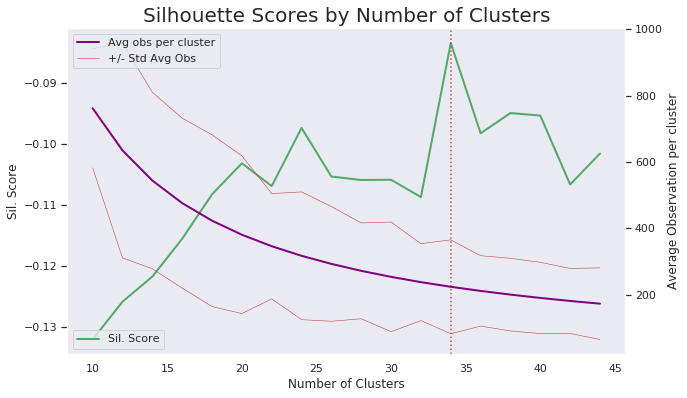

In [259]:
#Visualize Results
obsstd1 = [ i+j for i,j in zip(avgobs,obsstd)]
stdneg = [ i-j for i,j in zip(avgobs,obsstd)]

sns.set_context('notebook')
fig, ax = fig, ax = plt.subplots(figsize=(10,6))

ax2 = ax.twinx()
ax = sns.lineplot(nclusts, sscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(nclusts, avgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(nclusts,obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(nclusts,stdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=34,color='r',linestyle='dotted')
ax.legend(loc='lower left')
ax2.legend(loc='upper left')
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
#
plt.show()

In this chart we can see that the silhouette scores are pretty volitile (and low). The objective is to pick a cluster number with a relatively high silhouette score and a relatively even distribution of observations per cluster.  The chart seems to indicate that cluster numbers of ~25-40 appear to bethe best selection, and the red bands straddling the purple line indicates lower variance which suggests the distribution of observations per cluster is evening out.

At this point, I have decided to disregard the pre determined number of clusters (10+11) and elect to use 34 clusters. I chose 34 because of the score.

Lets reduce the dimensionality using both PCA and this time also t-SNE, (as it is said be good for visualization of texts.)

" t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results."

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

#### 34 Clusters reduced to two PCA components
    1. Reduce dimensionality to two components
    2. Cluster the data in 34 clusters using KMeans clustering
    3. Plot the results

Number of Clusters: 34




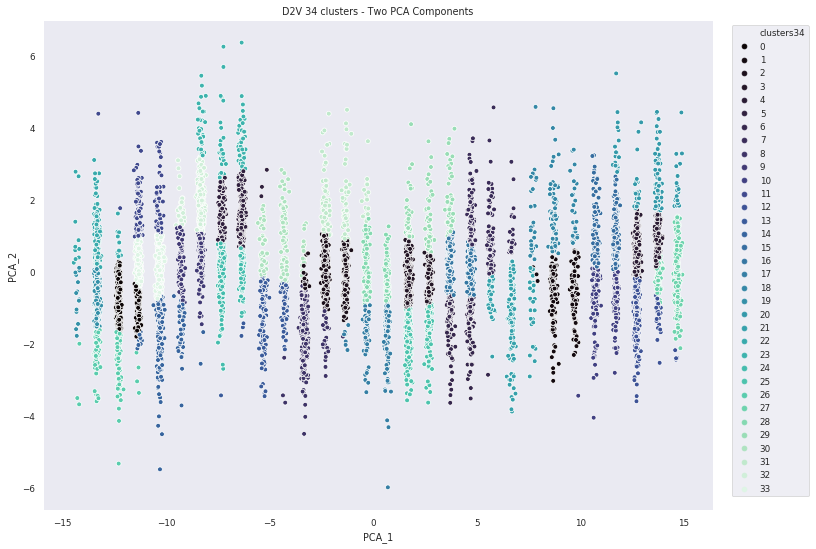

In [401]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)

#fit transform doc2vec word vectors
Y34 = pca.fit_transform(vecs)

#create dataframe for plotting, add comoonents,labels
pca_d2vclusters34 = pd.DataFrame()
pca_d2vclusters34['original'] = X_train
pca_d2vclusters34['Professor'] = y_train[:,0]
pca_d2vclusters34['Subject'] = y_train[:,1]
pca_d2vclusters34['PCA_1'] = Y34[:,0]
pca_d2vclusters34['PCA_2'] = Y34[:,1]
pca_d2vclusters34['filename'] = y_train[:,2]

#cluster the data
d2v_clusters34 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(Y34)    
print('Number of Clusters: 34')
# calculate and print silhouette average scores
#print('\nSilhouette Score {} clusters:'.format(silhouette_score(Y30, d2v_clusters30, metric='cosine'))
print('\n')
sns.set(context='paper',style='dark')
pca_d2vclusters34['clusters34'] = d2v_clusters34
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters34', data=pca_d2vclusters34,palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("D2V 34 clusters - Two PCA Components")   
plt.show()

#### 34 Clusters reduced to two PCA components
    1. Cluster the data in 34 clusters using KMeans clustering
    2. Reduce dimensionality to two components 
    3. Plot the results

Number of Clusters: 34




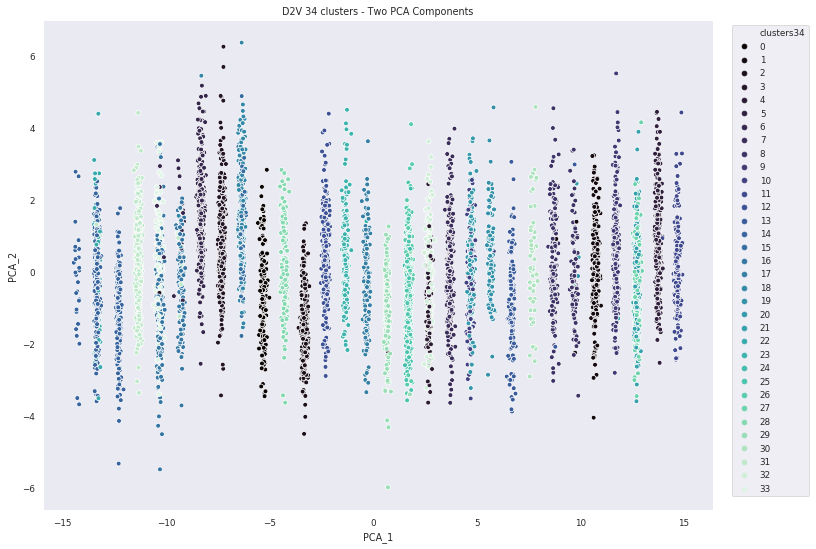

In [402]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)

pca_d2vclusters34 = pd.DataFrame()
pca_d2vclusters34['original'] = X_train
pca_d2vclusters34['Professor'] = y_train[:,0]
pca_d2vclusters34['Subject'] = y_train[:,1]

d2v_clusters34 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(vecs) 
#fit transform doc2vec word vectors
Y34 = pca.fit_transform(vecs)

#create dataframe for plotting, add comoonents,labels

pca_d2vclusters34['PCA_1'] = Y34[:,0]
pca_d2vclusters34['PCA_2'] = Y34[:,1]
pca_d2vclusters34['filename'] = y_train[:,2]

#cluster the data
   
print('Number of Clusters: 34')
# calculate and print silhouette average scores
#print('\nSilhouette Score {} clusters:'.format(silhouette_score(Y30, d2v_clusters30, metric='cosine'))
print('\n')
sns.set(context='paper',style='dark')
pca_d2vclusters34['clusters34'] = d2v_clusters34
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters34', data=pca_d2vclusters34,palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("D2V 34 clusters - Two PCA Components")   
plt.show()

We can see that when we reduce the original data to two clusters and then cluster the results, each verticle line of points shares multiple cluster groups, where as clustering the data first and then reducing the dimensionality leads to more consist cluster assignments for a given line.

Lets do the same with t-SNE

#### 34 clusters reduce with t-SNE to two components
    1. Cluster the data into 34 clusters with KMeans algorithm
    2. Reduce dimensionality to two components
    3. Plot the results

Number of Clusters: 24

Silhouette Score: -0.15310014546126882




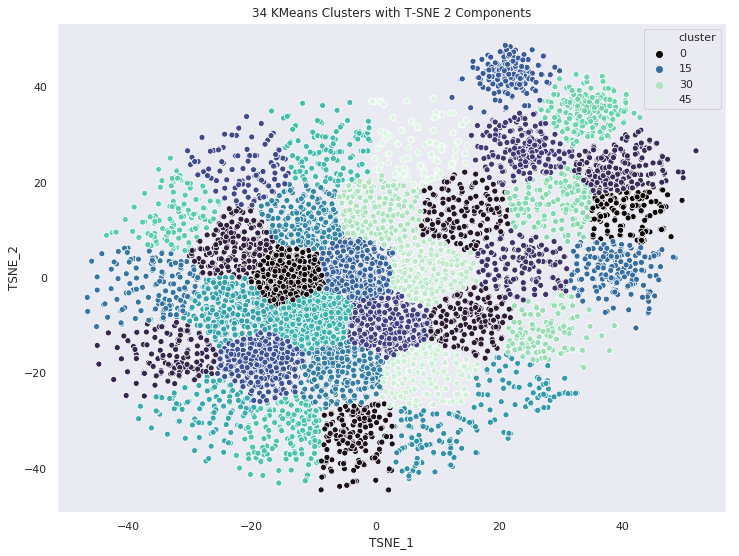

Time: 131.4823853969574 seconds.



In [403]:
t1 = time.time()
tsne2 = TSNE(n_components=2, random_state=43, metric='cosine')
tsne2_d2v = pd.DataFrame()
tsne2_d2v['original'] = X_train
tsne2_d2v['Professor'] = y_train[:,0]
tsne2_d2v['Subject'] = y_train[:,1]
tsne2_d2v['filename'] = y_train[:,2]

sns.set_context('paper')

#Reduce dimentionality
Yt = tsne2.fit_transform(vecs)
#Cluster the reduced data
d2v_clusters2 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(Yt)    
print('Number of Clusters: 24')
# calculate and print silhouette average scores
print('\nSilhouette Score:', silhouette_score(vecs, d2v_clusters2, metric='cosine'))
print('\n')


tsne2_d2v['TSNE_1'] = Yt[:,0]
tsne2_d2v['TSNE_2'] = Yt[:,1]
tsne2_d2v['cluster'] = d2v_clusters2

#plot the results
plt.figure(figsize=(12,9))
sns.set_context('notebook')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='cluster', data=tsne2_d2v, palette='mako')
plt.legend(loc='upper right')
# label the axes and set the chart title  
plt.title("34 KMeans Clusters with T-SNE 2 Components")
plt.show()

t2 = time.time()
print("Time: {} seconds.\n".format(t2-t1))



Number of Clusters: 34

Silhouette Score: -0.08337855812697163




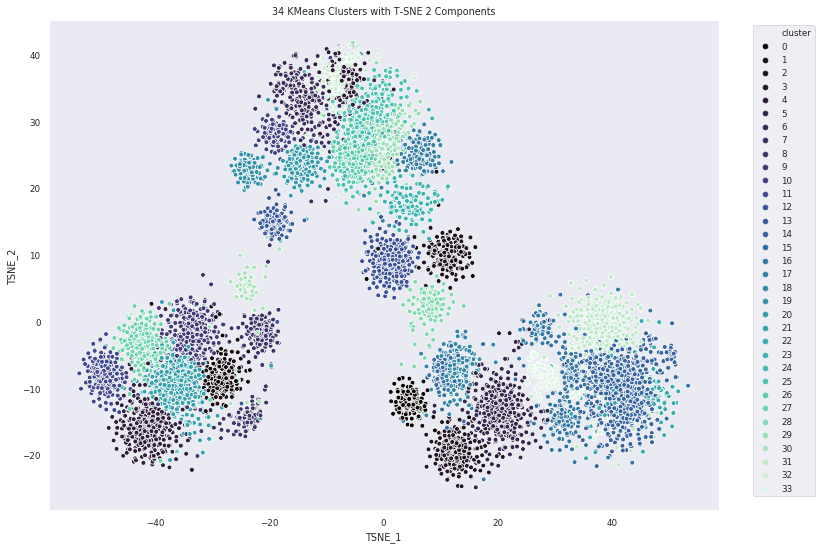


Avg Obs per cluster: 224.02941176470588

Number of observations per cluster:
14    773
21    492
6     430
31    346
25    336
16    329
5     314
12    295
9     268
7     264
3     264
8     255
dtype: int64
Time: 139.3367223739624 seconds.



In [267]:
#instantiate TSNE, set up a dataframe for graphing
tsne = TSNE(n_components=2,random_state=43)
tsne_d2v = pd.DataFrame()
tsne_d2v['original'] = X_train
tsne_d2v['Professor'] = y_train[:,0]
tsne_d2v['Subject'] = y_train[:,1]
tsne_d2v['filename'] = y_train[:,2]

t1 = time.time()
d2v_clusters = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(vecs)    
print('Number of Clusters: 34')
# calculate and print silhouette average scores
print('\nSilhouette Score:', silhouette_score(vecs, d2v_clusters, metric='cosine'))
print('\n')

Yt = tsne.fit_transform(vecs)
tsne_d2v['TSNE_1'] = Yt[:,0]
tsne_d2v['TSNE_2'] = Yt[:,1]
tsne_d2v['cluster'] = d2v_clusters
plt.figure(figsize=(12,9))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='cluster', data=tsne_d2v, palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("34 KMeans Clusters with T-SNE 2 Components")
plt.show()
print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
print('Number of observations per cluster:')
print(pd.value_counts(d2v_clusters)[:12])    
t2 = time.time()
print("Time: {} seconds.\n".format(t2-t1))

In [404]:
#interesting shape!

#### Select a few clusters and look at sentences

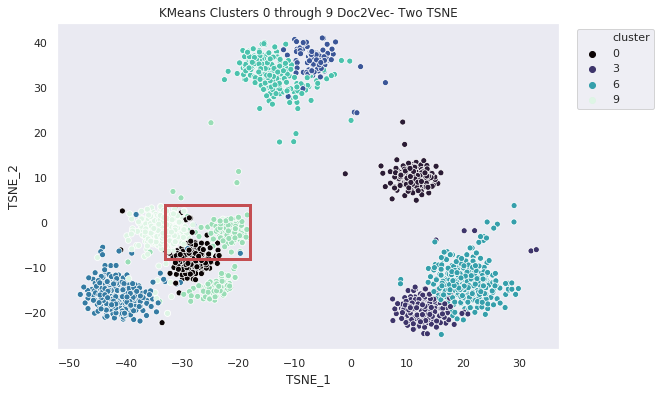

In [418]:
ts = tsne_d2v.copy()
keeps = [ i for i in ts.index if ts.cluster[i] >= 1 and ts.cluster[i] <= 9]
ts = ts.iloc[keeps]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
ax = sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='cluster', 
                data=ts,
                palette='mako')
rect = patches.Rectangle((-33,-8),15,12,linewidth=3,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
#for label, x, y in zip(tsned2v33.original,tsned2v33.TSNE_1,tsned2v33.TSNE_2):
    #plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

#plt.xlim(-2,2)
#plt.ylim(-10,10)

plt.title('KMeans Clusters 0 through 9 Doc2Vec- Two TSNE')
plt.legend(bbox_to_anchor=[1.2,1],loc='upper right')
plt.show() 

plt.show()

In [419]:
#look at the intersection of the three clusters

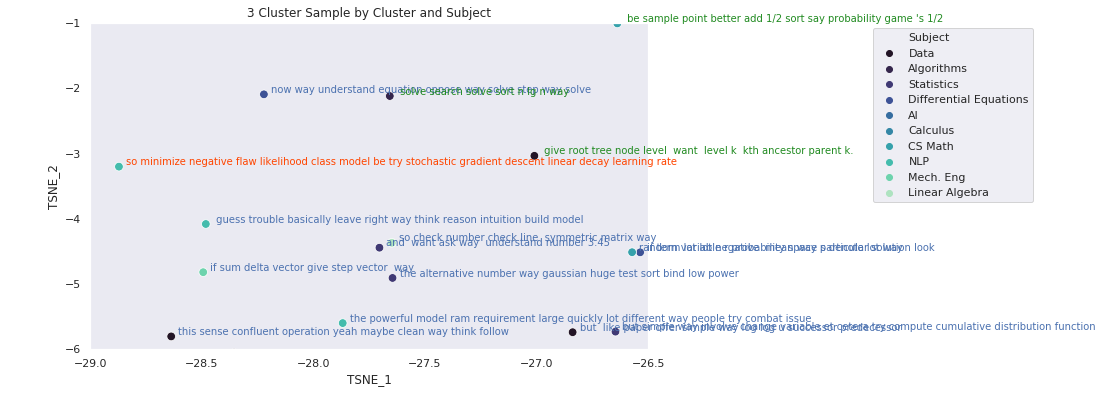

In [421]:
tsned2v33 = tsne_d2v[tsne_d2v['cluster'] <= 4]
plt.figure(figsize=(10,6))
sns.set_context('notebook')
ax = sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='Subject', 
                data=ts,
                palette='mako', s=75)
for i, clust in enumerate(tsned2v33.cluster):
    colors=['r','b','g','purple','orange','teal','c','m','forestgreen','orangered','limegreen']
    ltsned2v33 = ts[ts.cluster == i]
    for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
        plt.annotate(label, xy=(x, y), xytext=(7, 2), color=colors[i], textcoords='offset points',fontsize=10)

plt.xlim(-29,-26.5)
plt.ylim(-6,-1)
plt.title('3 Cluster Sample by Cluster and Subject')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

### Intracluster similarity of sentences
The subjects of each cluster aren't clear yet. We need to look at each cluster and examine how similar it's sentences are to each other. To do this we will use the cosine similarity matrix to calculate the intracluster similarity of each sentence Then we will visually inspect the results to determine any patterns, topics etc.

In [430]:
#We need to add the cluster numbers to the vecs dataframe
subsprofs = pd.DataFrame(y_train)
subsprofs['cluster_no'] = d2v_clusters
subsprofs[3] = X_train
vecs['cluster_no'] = d2v_clusters
for_sims = pd.DataFrame(X_train)
for_sims['cluster_no'] = d2v_clusters

In [230]:
# this function iterates over clusters and calculates the average cosine similarity score of sentences
#For each cluster, a dictionary stores cluster level information as keys and returns a data frame
#with the 'num_sents'(int) most related sentences as rows and the lecture source and intracluster mean similarity
#as columns
n_clusters = 34
def get_similarities(num_sents):    
    sim_sents = OrderedDict()
    lects = OrderedDict()
    mean_sims = {}
    
    # iterate over clusters
    for i in range(n_clusters):
        tmpdf = vecs[vecs.cluster_no == i]
        tmpdf = tmpdf.drop(['cluster_no'],1)
        tmp1 = for_sims[for_sims.cluster_no == i ]
        tmp1 = tmp1.drop(['cluster_no'],1)
        # calculate cosine similarity with Sklearn's cosine_similarity method and store in dataframe
        df_sim = pd.DataFrame(cosine_similarity(tmpdf), index=range(len(tmp1)), columns=tmp1)          
        # insert a column with the average similarity score of each row in the similarity matrix
        df_sim.insert(0, 'mean_similarity', df_sim.mean(axis=1)) 
        df_sim.insert(0, 'lecture', subsprofs[subsprofs.cluster_no == i][2].reset_index(drop=True))
        df_sim.insert(0, 'original_sentence', tmp1.reset_index(drop=True))
        # calculate the cluster's global average similarity score
        mean_similarity = df_sim.mean_similarity.mean()        
        # store the cluster's global average similarity score in a dictionary
        mean_sims['cluster {}'.format(i)] = mean_similarity
        mean_sims['cluster {}'.format(i)] = mean_similarity
        #the DataFrame will be the dictionary value
        top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]
        # store the most similar sentence and the average similarity score of clusters
        sim_sents['cluster_{} | {} sentences | mean similarity: {}'.format(
            i, df_sim.shape[0], mean_similarity)] = top_sents

    return sim_sents, mean_sims

In [57]:
#call the function for 10 sentences per cluster
ten_sents, mean_sims = get_similarities(10)

In [58]:
#For each cluster, examine the top 10 most similar sentences in each cluster, along with the source
for i in ten_sents:
    vals = ten_sents[i]
    print('\n{}'.format(i))
    print('\nOriginal Sentence\n\n{}\n\nLecture\n\n{}\\nnMean_sim\n\n{}'.format(
        vals.original_sentence,vals.lecture,vals.mean_similarity))


cluster_0 | 129 sentences | mean similarity: 0.2754561303278443

Original Sentence

67    and basically main takeaway message blue layer...
15     basically horizontally fall ladder cover need...
16    and vector capture core occurrence account bas...
44    and basically term basically wanna maximize lo...
79     basically bunch input say castle north beach ...
59    so basically intuitively  rephrase question an...
85    and apply newton 's method  go symbolic equati...
20    and cosine relation sine basically square root...
51    basically kind model mechanism compute represe...
52    basically question class important know f1 met...
Name: original_sentence, dtype: object

Lecture

67       manningnlp8
15     demainedata15
16        sochernlp3
44        sochernlp3
79       sochernlp16
59       sochernlp16
85    devadasalgos12
20     aurouxmcalc11
51       sochernlp16
52       manningnlp8
Name: lecture, dtype: object\nnMean_sim

67    0.369770
15    0.369587
16    0.363057
44    0.35

## Assessing the clusters
 - After calculating the intercluster similarities, some real patterns have started to emerge.
     - The clusters appear to exhibit the same characteristics as before (ie identifying the same word use in different sentences) however, with 34 clusters (we looked at 10, 11 before) some clusters seem to have more relavent similar sentences, even topics. For example, the topic of cluster 33 is clearly probability, not only do the sentences suggest it, but the sentence sources suggest it could be the 'topic' of the cluster. (other sentences pertaining to probability also show up in other clusters) Other clusters on the other hand do not share this 'topic' characteristic.  For instance cluster 25 is a eclectically sourced collection of sentences starting with the word 'but'.
     
   - Note that this analysis was true of the first iteration of the notebook. The clusters do not have the same assigned sentences if ran again. However, after running the Kmeans on the data multiple times, the same sentences seems to get clustered together, just in a different cluster assignments


#### Examining Word Frequencies
     - By extracting the word frequencies and subject/professor/lecture density of each cluster, maybe we can draw new insight.

In [59]:
#this function removes any 's in the text, tokenizes and stems the word
def clean_lite (text):
    re.sub(" 's",'',text)
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if len(word) > 3]
    words = [word for word in words if word not in default_stopwords]
    #words = [stemmer.stem(word) for word in words]
    return words    

In [60]:
#add the sentences to our previous dataframe
subsprofs[3] = X_train

In [61]:
subsprofs.head()

0           1                2  cluster_no  \
0  Rigollet  Statistics   rigolletstats3           3   
1   Devadas  Algorithms    devadasalgos4          28   
2   Devadas  Algorithms   devadasalgos10          10   
3   Devadas  Algorithms    devadasalgos1          17   
4  Rigollet  Statistics  rigolletstats13          29   

                                                   3  
0  and non parametric estimation typically actual...  
1  now discard node n heap simply decrement heap ...  
2  so probabilistic argument assume hash function...  
3  then guess 2d peak great equal b great equal d...  
4  then  say  want y plus bx  go add noise epsilo...

In [62]:
#iterate over each cluster, 
#convert all sentences in each cluster to one str
#tokenize, stem words, count frequencies of words, subjects, professors and lecture id
for i in sorted(subsprofs.cluster_no.unique()):
    #iterate by cluster
    cluster_df = subsprofs[subsprofs.cluster_no == i].reset_index(drop=True)
    #Make one large string
    cluster_str = ' '.join([ ' '.join([i]) for i in cluster_df[3]]) 
    #run lite cleaner
    cluster_str = clean_lite(cluster_str)
    
    fdist = nltk.FreqDist(cluster_str)
    freq_words = list(Counter(fdist).most_common(5))
    profs = Counter(dict(cluster_df[0].value_counts())).most_common(5)
    subs = Counter(dict(cluster_df[1].value_counts())).most_common(5)
    lects = Counter(dict(cluster_df[2].value_counts())).most_common(5)
    print('Cluster Number: {}, Sentences: {}\n Words and Counts:{}\n Professors: {}\n Subjects:{}\n Lectures: {}\n'.format(\
        i,cluster_df.shape[0],freq_words,profs,subs, lects))

Cluster Number: 0, Sentences: 129
 Words and Counts:[('basically', 123), ('time', 18), ('compute', 16), ('word', 15), ('different', 14)]
 Professors: [('Socher', 49), ('Rigollet', 25), ('Manning', 19), ('Demaine', 17), ('Devadas', 8)]
 Subjects:[('NLP', 68), ('Statistics', 25), ('Data', 17), ('Algorithms', 8), ('Calculus', 6)]
 Lectures: [('sochernlp16', 18), ('manningnlp8', 17), ('sochernlp13', 14), ('sochernlp3', 12), ('rigolletstats11', 7)]

Cluster Number: 1, Sentences: 139
 Words and Counts:[('theta', 227), ('minus', 23), ('time', 20), ('equal', 20), ('function', 20)]
 Professors: [('Rigollet', 75), ('Devadas', 15), ('Jerison', 13), ('Mattuck', 12), ('Auroux', 10)]
 Subjects:[('Statistics', 75), ('Calculus', 23), ('Algorithms', 15), ('Differential Equations', 12), ('CS Math', 5)]
 Lectures: [('rigolletstats17', 18), ('rigolletstats5', 17), ('rigolletstats21', 15), ('jerisoncalc3', 13), ('rigolletstats3', 12)]

Cluster Number: 2, Sentences: 194
 Words and Counts:[('think', 202), ('

Cluster Number: 28, Sentences: 258
 Words and Counts:[('plus', 49), ('time', 47), ('square', 39), ('number', 26), ('space', 19)]
 Professors: [('Demaine', 91), ('Leighton', 77), ('Devadas', 42), ('Rigollet', 23), ('Strang', 13)]
 Subjects:[('Data', 91), ('CS Math', 77), ('Algorithms', 42), ('Statistics', 23), ('Linear Algebra', 8)]
 Lectures: [('demainedata15', 29), ('demainedata8', 23), ('leighton12cssums', 16), ('demainedata14', 15), ('leighton15linearcs', 14)]

Cluster Number: 29, Sentences: 247
 Words and Counts:[('want', 277), ('like', 25), ('thing', 21), ('tell', 20), ('right', 18)]
 Professors: [('Rigollet', 72), ('Demaine', 28), ('Devadas', 27), ('Strang', 27), ('Jerison', 18)]
 Subjects:[('Statistics', 72), ('Data', 28), ('Algorithms', 27), ('Calculus', 26), ('NLP', 26)]
 Lectures: [('rigolletstats17', 11), ('rigolletstats8', 11), ('rigolletstats5', 11), ('winstonai10', 9), ('rigolletstats1', 8)]

Cluster Number: 30, Sentences: 478
 Words and Counts:[('model', 36), ('like', 35

After examing the occurance frequencies of each tokens and their identifying labels, we see some support for our hypothesis. For instance the word probability occurs 184 times, while the next common word is 'equal' with 21 counts. In fact 19 of the 34 clusters have a word that is present at least more than 4 four times than the second most frquently occuring word, in some clusters that rate is almost 10.
 - Clusters with dominant words:
     - 1,3,5,6,7,8,10,14,15,16,19,20,21,24,26,28,30,32,33
 - Clusters with out dominant words include those not listed above. The most common words occur at a rate less than 2 twice the second word, and do not really seem to be related to any particular topic. The word 'actually' shows up alot.
 -  A last observation is the similarities between clusters 30 and 32 where the 2 most common words are 'need' and 'know' - and - 'know' and 'want'. As in 'i need to know x, once i have x i want to y'
 
While this analysis shed some light on new patterns not seen before, we can use another technique called NonNegative Matrix Factorization. We will apply a minMax scaler to that data move all the data points positive between 0 and 1. then for each cluster we will apply the fit and see how the sentences are groups. This is a common way of finding subtopics with clusters.

In [432]:
#define a function to extract subtopics

def nmf_topics(vec_matrix, num_sents):
    sim_sents = OrderedDict()
    
    for i in range(n_clusters):
        tmp1 = subsprofs[subsprofs.cluster_no == i]
        temp_matrix = vecs
        temp_matrix['cluster_no'] = subsprofs.cluster_no
        temp_matrix = temp_matrix[temp_matrix.cluster_no == i]
        temp_matrix = minmax_scale(temp_matrix.drop(['cluster_no'],1))
        n_comps = int(np.ceil(temp_matrix.shape[0] * .01)) #100 sentences per component
        #Instaniate a NMF instance 

        nmf = NMF(alpha=0.35, 
                  init='nndsvdar', # how starting value are calculated
                  l1_ratio=0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
                  max_iter=400, # when to stop even if the model is not converging (to prevent running forever)
                  n_components=n_comps, 
                  random_state=43, 
                  solver='cd', # Use Coordinate Descent to solve
                  tol=0.0001, # model will stop if tfidf-WH <= tol
                  verbose=1) # amount of output to give while iterating
        components = nmf.fit_transform(temp_matrix)
        df_components = pd.DataFrame(components, index=tmp1[[2,3]])
        df_components.insert(0, 'sentence',tmp1[3])
        df_components.insert(0, 'lecture',tmp1[2].reset_index(drop=True))
                                    
        for col in df_components.columns[2:]:
            top_sents = df_components[col].sort_values(ascending=False)[:num_sents].index
            sim_sents['cluster_{}, component {}'.format(i, col)] = top_sents
        
        print('Cluster {}: {} observations , {} components'.format(i, temp_matrix.shape[0],n_comps))
    
    return sim_sents



In [435]:
#Call the function
cluster_topics = nmf_topics(vecs, 10)

violation: 1.0
violation: 0.4893509345646425
violation: 0.3997618799259582
violation: 0.3308452790253259
violation: 0.28176702499790013
violation: 0.24525723337045174
violation: 0.21619006477130873
violation: 0.1939367314184491
violation: 0.17541254944473397
violation: 0.15977099132385944
violation: 0.14619810509733228
violation: 0.13435883413533425
violation: 0.12425824293017942
violation: 0.1151711468948441
violation: 0.10704402235929983
violation: 0.09964255761892409
violation: 0.0928441946574276
violation: 0.0869078520157146
violation: 0.08137276166593674
violation: 0.07656151090115614
violation: 0.07207687696389597
violation: 0.06812813758401312
violation: 0.06478000007420119
violation: 0.06180263997944678
violation: 0.059183601114258064
violation: 0.056777874048987674
violation: 0.05451710920380995
violation: 0.052417640808386255
violation: 0.050469648150175205
violation: 0.048649769911964215
violation: 0.04698335787859317
violation: 0.04544358806061257
violation: 0.0441251465683

violation: 0.00678044016358201
violation: 0.006756298205583688
violation: 0.006732232630474817
violation: 0.006708243412390254
violation: 0.006684330515550423
violation: 0.00666049389461442
violation: 0.006636733495036384
violation: 0.0066130492534804556
violation: 0.0065894410980801114
violation: 0.00656590894889377
violation: 0.006542452718115044
violation: 0.0065190723104350925
violation: 0.006495767623394991
violation: 0.006472538547765956
violation: 0.006449389854219286
violation: 0.006426327587210773
violation: 0.006403340204436142
violation: 0.006380427577962465
violation: 0.006357589574249009
violation: 0.006334826054611584
violation: 0.006312136875300292
violation: 0.0062895218879436545
violation: 0.006266980939554882
violation: 0.006244513873006974
violation: 0.006222120527090951
violation: 0.0061998007368423615
violation: 0.006177554333669073
violation: 0.006155381145593751
violation: 0.006133280997543226
violation: 0.006111253711313315
violation: 0.006089299105971785
violat

violation: 0.005677193372138862
violation: 0.00566462456598892
violation: 0.005652081229194221
violation: 0.005639563277461616
violation: 0.005627070627786281
violation: 0.005614603198386821
violation: 0.0056021609085495465
violation: 0.005589743678785831
violation: 0.0055773514306601555
violation: 0.005564984086837026
Cluster 1: 197 observations , 2 components
violation: 1.0
violation: 0.5056194785168883
violation: 0.4138155675344003
violation: 0.3468095404418215
violation: 0.2962750769114074
violation: 0.2576397995879827
violation: 0.2269212090662019
violation: 0.20088687877832884
violation: 0.17899174417752095
violation: 0.16013134783822594
violation: 0.14462088361576672
violation: 0.13185308418485933
violation: 0.12102571293572306
violation: 0.11327466947331301
violation: 0.10677054471019903
violation: 0.10134452841980143
violation: 0.09664136805985296
violation: 0.0923281407460686
violation: 0.0884484813404153
violation: 0.084830031297999
violation: 0.08136615660654477
violation: 

violation: 1.0
violation: 0.4623898151472592
violation: 0.37836266040788935
violation: 0.32523171168007703
violation: 0.2834770774440532
violation: 0.2493280654781341
violation: 0.22275318524467244
violation: 0.20056042588705078
violation: 0.18196513512039986
violation: 0.16594215494572484
violation: 0.15193311888175642
violation: 0.1400974863027651
violation: 0.12994520940298748
violation: 0.12120754150618843
violation: 0.11358019987138165
violation: 0.10684242082556808
violation: 0.10071924587782229
violation: 0.09543803280268247
violation: 0.09066422875284673
violation: 0.08635951257217422
violation: 0.08240789907644729
violation: 0.07879529016685799
violation: 0.07559277487559316
violation: 0.07281464312074136
violation: 0.07020765527659198
violation: 0.06787396575424302
violation: 0.06565846471630807
violation: 0.06356462555845153
violation: 0.06160423709615558
violation: 0.05977413294884416
violation: 0.0580510990725312
violation: 0.05636118343109204
violation: 0.0547320491021323

violation: 0.07152169436226237
violation: 0.0687269053698576
violation: 0.06604932434751483
violation: 0.06348284756127992
violation: 0.06113958694928143
violation: 0.05894948145074877
violation: 0.056806118476727084
violation: 0.054807375167387214
violation: 0.0529967968839375
violation: 0.051436806761905284
violation: 0.049993744638608985
violation: 0.048588047547586166
violation: 0.04727660439424492
violation: 0.04603319535868472
violation: 0.044866121133398246
violation: 0.04375775143060682
violation: 0.04271040951468586
violation: 0.04173949799769945
violation: 0.040807596293494446
violation: 0.039913691179319935
violation: 0.03907110377290105
violation: 0.03828969525233281
violation: 0.03754489277313811
violation: 0.03683121400119258
violation: 0.03620508381755612
violation: 0.03561825660667006
violation: 0.03505267852268159
violation: 0.03453088814879866
violation: 0.03404221573928642
violation: 0.03357666794365633
violation: 0.03313050400584122
violation: 0.03270651637745423
vi

violation: 0.005828648102773165
violation: 0.005809906846750251
violation: 0.005791464422986253
violation: 0.0057732858414453
violation: 0.005755341784641353
violation: 0.005737607828830786
violation: 0.005720063586021934
violation: 0.005702737011637967
violation: 0.005685805760745634
violation: 0.0056691118412930406
violation: 0.0056525289295741585
violation: 0.0056360491425437404
violation: 0.005619956837503762
violation: 0.005604130701096908
violation: 0.005588355672831938
violation: 0.0055726307637099974
violation: 0.0055569550168800465
violation: 0.0055413275161342685
violation: 0.005525747390852513
violation: 0.005510213817783142
violation: 0.005494726021236618
violation: 0.005479283272129777
violation: 0.005463884886204838
violation: 0.00544853022189955
violation: 0.005433218677916731
violation: 0.005417949690731424
violation: 0.005402722732071491
violation: 0.005387595373886791
violation: 0.005372520785628543
violation: 0.005357484130201979
violation: 0.005342485099216331
viola

violation: 0.009869600602377836
violation: 0.009836017186943102
violation: 0.009802624942667145
violation: 0.00976942237999269
violation: 0.009736448988586959
violation: 0.009703708251052484
violation: 0.009671270033452431
violation: 0.009639048034713734
violation: 0.00960703826104504
violation: 0.009575208873789678
violation: 0.009543557205926874
violation: 0.009512080640562203
violation: 0.009480776642751744
violation: 0.00944965586388422
violation: 0.009418768195845842
violation: 0.009388044285275012
violation: 0.009357515167247808
violation: 0.009327146966546776
violation: 0.009296935800698772
violation: 0.009266879808935945
violation: 0.0092369771680631
violation: 0.009207226087911512
violation: 0.00917763087627331
violation: 0.009148198039715148
violation: 0.009118911245686047
violation: 0.009089781167673705
violation: 0.00906090146146694
violation: 0.009032203376942764
violation: 0.009003690906425964
violation: 0.008975314655037476
violation: 0.008947073003249621
violation: 0.00

violation: 0.012148670297758927
violation: 0.01207598879988181
violation: 0.012003569848708512
violation: 0.011931468102643812
violation: 0.011859690336915137
violation: 0.011788289356614743
violation: 0.011717916246836027
violation: 0.011648996760415883
violation: 0.01158000900223886
violation: 0.011511173774223442
violation: 0.011442662412609429
violation: 0.011374430000313534
violation: 0.011306885742695295
violation: 0.011240076297987298
violation: 0.011173693031861923
violation: 0.01110783710668723
violation: 0.011042570523059528
violation: 0.010977753314712058
violation: 0.010913665987384698
violation: 0.010850946356346204
violation: 0.010788643363032247
violation: 0.010727013056529604
violation: 0.01066672956693812
violation: 0.010607461044041071
violation: 0.010548582090729544
violation: 0.010489690666091778
violation: 0.010431041240472635
violation: 0.010372698510524447
violation: 0.010314749552834953
violation: 0.010257118102420231
violation: 0.010199890183432807
violation: 0

violation: 0.014088956212179553
violation: 0.013990866736563747
violation: 0.013893152684003157
violation: 0.013795780073560759
violation: 0.013698742637283257
violation: 0.013602061305433387
violation: 0.013505796333220028
violation: 0.013409894191374118
violation: 0.013314358712216081
violation: 0.013219197584245439
violation: 0.013124417990561256
violation: 0.0130300266659261
violation: 0.012936033089806028
violation: 0.012842475579359558
violation: 0.012749324201225591
violation: 0.012666613136802451
violation: 0.012581146711551264
violation: 0.012502384043186949
violation: 0.012426869792796648
violation: 0.012354538694197847
violation: 0.01228144936600706
violation: 0.012208436998226208
violation: 0.012135617418983054
violation: 0.012063126226645996
violation: 0.01199099745430081
violation: 0.01191922287501893
violation: 0.01184777997613379
violation: 0.011776705544197828
violation: 0.011705944898460613
violation: 0.01163543972620449
violation: 0.011565177770188687
violation: 0.01

violation: 0.06404825716249996
violation: 0.061505112114576516
violation: 0.05912776387516274
violation: 0.05699457066216587
violation: 0.054974183026306446
violation: 0.053130941816001295
violation: 0.05143311808777936
violation: 0.04991976329082606
violation: 0.04850460319799688
violation: 0.047150653279461906
violation: 0.04586273185790737
violation: 0.044617030489919315
violation: 0.043479035272036656
violation: 0.0424534888802413
violation: 0.04151235736026908
violation: 0.040582622252495384
violation: 0.03968055104879936
violation: 0.03880560188916668
violation: 0.03795577734275448
violation: 0.037120107489006716
violation: 0.03633227316758137
violation: 0.03555638156433638
violation: 0.03479511594252964
violation: 0.03406333625045893
violation: 0.03335828475926372
violation: 0.03268222235275359
violation: 0.03202727304108631
violation: 0.031390144803374175
violation: 0.030783787927930593
violation: 0.030205940948173166
violation: 0.02964282521251775
violation: 0.0291217834734718

violation: 0.039383061676278905
violation: 0.038693665029895234
violation: 0.0380259433706976
violation: 0.03737999245143697
violation: 0.036748422129815946
violation: 0.03615277165662379
violation: 0.03558899511554146
violation: 0.03505362278474444
violation: 0.0345183059883822
violation: 0.03399421675879979
violation: 0.0334799852563151
violation: 0.03297691375746649
violation: 0.03248144225180609
violation: 0.032003865395068304
violation: 0.031525705644685445
violation: 0.031055493109844325
violation: 0.030603853089298857
violation: 0.030174843253016278
violation: 0.029752376274562533
violation: 0.02933740159011926
violation: 0.028939042465483327
violation: 0.02858021551117795
violation: 0.028247854417243718
violation: 0.02791970114347551
violation: 0.027599667504398812
violation: 0.027290441723905247
violation: 0.026989115206481996
violation: 0.026694776119513083
violation: 0.02640677241800596
violation: 0.02612344376636909
violation: 0.02584556828299431
violation: 0.02557922351744

violation: 0.023327823870808055
violation: 0.023158312825386634
violation: 0.023015647388828057
violation: 0.022859929899974686
violation: 0.022705873681772775
violation: 0.022555994509070473
violation: 0.02240927979662737
violation: 0.022264809524957296
violation: 0.022122135002347804
violation: 0.021980937779753185
violation: 0.021840992434479317
violation: 0.021702139251971224
violation: 0.021564264708248605
violation: 0.02142728772061554
violation: 0.021291150025955524
violation: 0.021155809459504366
violation: 0.021021235256333218
violation: 0.0208874047567842
violation: 0.02075434625932696
violation: 0.020622293685608587
violation: 0.020490925208630925
violation: 0.020360472983850946
violation: 0.02023079173048154
violation: 0.02010177220576643
violation: 0.019973411791944614
violation: 0.019845708277301324
violation: 0.01971865972260231
violation: 0.019592264366039988
violation: 0.019477398124198457
violation: 0.019386194072852234
violation: 0.019291218912495134
violation: 0.019

violation: 0.010413186715258278
violation: 0.010357220445021863
violation: 0.010301521464578182
violation: 0.010246088944322315
violation: 0.010190922050381407
violation: 0.010136019944686348
violation: 0.010081381785068793
violation: 0.010027006725526963
violation: 0.009972893916369198
violation: 0.009919042504339717
violation: 0.009865451632652658
violation: 0.009812120441301576
violation: 0.009759422957439801
violation: 0.009711936062587377
violation: 0.009674477471240762
violation: 0.009636915301657806
violation: 0.009599593032707717
violation: 0.009562759129534172
violation: 0.009526496483477094
violation: 0.009490808818077226
violation: 0.009455665192876961
violation: 0.00942111222900072
violation: 0.009387270169700843
violation: 0.009353816248894512
violation: 0.009320713831653405
violation: 0.009287931480290303
violation: 0.009255442401347638
violation: 0.0092235744943622
violation: 0.009192796114687176
violation: 0.009162149319399264
violation: 0.009131632813874711
violation: 

violation: 0.010291828229175034
violation: 0.0102332525072531
violation: 0.010175039336577903
violation: 0.010117184357268104
violation: 0.010059683428854362
violation: 0.010002532619426255
violation: 0.009945728192804865
violation: 0.009889266594619042
violation: 0.009833144438309358
violation: 0.009777358491177965
violation: 0.009721905661592851
violation: 0.009666782986609446
violation: 0.009611987620942659
violation: 0.009557516826752006
violation: 0.009503367964459117
violation: 0.009449538484512321
violation: 0.009396025919917717
violation: 0.009342827879513313
violation: 0.00928994204198811
violation: 0.009237366150413382
violation: 0.009185098007313297
violation: 0.009133135470253875
violation: 0.009081476447829072
violation: 0.00903011889590977
violation: 0.008979060814433771
violation: 0.00892830024424636
violation: 0.00887783526437717
violation: 0.0088276639895314
violation: 0.008777784567707189
violation: 0.008728195178063461
violation: 0.008678894028965121
violation: 0.008

violation: 0.01483453207741386
violation: 0.014800289541022844
violation: 0.01476609899418497
violation: 0.014731960391810833
violation: 0.014697873690834423
violation: 0.0146638388503418
violation: 0.01462985583140606
violation: 0.014595924597040575
violation: 0.014562045112175667
violation: 0.014528217343519143
violation: 0.014494441259574676
violation: 0.014460716830562508
violation: 0.01442704402825294
violation: 0.014393422826180145
violation: 0.014359853199236184
violation: 0.014326335123911151
violation: 0.014292868578069766
violation: 0.014259453541031624
violation: 0.014226089993358929
violation: 0.014192777916944926
violation: 0.01415951729496357
violation: 0.014126308111680566
violation: 0.014093150352615724
violation: 0.01406004400433488
violation: 0.014026989054442104
violation: 0.013993985491684569
violation: 0.013961033305665603
violation: 0.013928132486966126
violation: 0.013895283027167497
violation: 0.013862484918597
violation: 0.013829738154431644
violation: 0.013797

violation: 0.011320776309526924
violation: 0.01124740112237081
violation: 0.011175228757192538
violation: 0.011106571854514273
violation: 0.011025252344369582
violation: 0.01095199576763516
violation: 0.010879663464767876
violation: 0.010809341265315426
violation: 0.010740065064603824
violation: 0.01067167077654387
violation: 0.01060429611176987
violation: 0.010532432098619206
violation: 0.010464464310180123
violation: 0.010397412988648682
violation: 0.010330385496926428
violation: 0.010262270675916103
violation: 0.010197119365109928
violation: 0.010132869589274104
violation: 0.01006900370409008
violation: 0.010006148931451015
violation: 0.00994412713269049
violation: 0.009882573734302466
violation: 0.009822216368977283
violation: 0.009762074875393358
violation: 0.009702505439083867
violation: 0.009644005583081906
violation: 0.009586759788269379
violation: 0.0095304367383236
violation: 0.00947468524284838
violation: 0.009418770359414866
violation: 0.009363895331975382
violation: 0.0093

violation: 0.03779879902439978
violation: 0.03676305622407604
violation: 0.0357937756165385
violation: 0.03488899324768794
violation: 0.03400812117748008
violation: 0.03317868360204649
violation: 0.03239092194438195
violation: 0.03160885994309915
violation: 0.030856311626755163
violation: 0.030165700791802145
violation: 0.02951811787694051
violation: 0.028897548875474275
violation: 0.02829525418702766
violation: 0.027713431044667163
violation: 0.02714753832186542
violation: 0.02659937423927102
violation: 0.026075877308826885
violation: 0.025582851897972686
violation: 0.025102348028841166
violation: 0.024636860423477475
violation: 0.024177018626269784
violation: 0.023729029387383846
violation: 0.02329554512516405
violation: 0.02287011947485658
violation: 0.022454166297759735
violation: 0.022047582921987493
violation: 0.021651230150167025
violation: 0.021262887446836052
violation: 0.02088498466328385
violation: 0.020521690872343495
violation: 0.020179026382861794
violation: 0.01985584498

violation: 0.04458932649622921
violation: 0.04392991172151202
violation: 0.04328097493852335
violation: 0.042641384394997116
violation: 0.04201031753085609
violation: 0.0413872101740529
violation: 0.04077200112091067
violation: 0.040165444353475875
violation: 0.03956596512642914
violation: 0.038973450300110596
violation: 0.038389512478983936
violation: 0.03781269854617186
violation: 0.037242711406618556
violation: 0.03668037308015182
violation: 0.03612476488778821
violation: 0.035575865234532496
violation: 0.03503365420445417
violation: 0.034498112307928396
violation: 0.03396921963912285
violation: 0.033446955309562425
violation: 0.032933025707987215
violation: 0.03242699423931419
violation: 0.031966288563269475
violation: 0.03149270354756671
violation: 0.031031632057845846
violation: 0.030583222474106112
violation: 0.03014359907439793
violation: 0.029711860819002872
violation: 0.029287863143622594
violation: 0.028870879131530656
violation: 0.028460539100323468
violation: 0.02805682834

violation: 0.00632840831044811
violation: 0.0062799859007404745
violation: 0.006232950103037325
violation: 0.006187869194844089
violation: 0.006143968478445349
violation: 0.006100398190472755
violation: 0.006057154730093739
violation: 0.006017975669595267
violation: 0.00598194742821915
violation: 0.005942993023231359
violation: 0.005906160970279133
violation: 0.005870909598993871
violation: 0.005837519802790092
violation: 0.00580607115662343
violation: 0.005774817723327877
violation: 0.005743767992742776
violation: 0.005712923518557898
violation: 0.005682283296490179
violation: 0.005651845542487561
violation: 0.0056216083630593345
violation: 0.005591569967108399
violation: 0.005561728699452951
violation: 0.005532083013720433
violation: 0.005502631432008448
violation: 0.0054733725084278794
violation: 0.005444304801751769
violation: 0.005415426856805834
violation: 0.0053867371931801125
violation: 0.0053582342996162284
violation: 0.0053299166322212195
violation: 0.005301782615649591
viola

violation: 0.003939018870577621
violation: 0.003927054070080828
violation: 0.003915254749740211
violation: 0.0039035663759992524
violation: 0.0038919648839556872
violation: 0.003880446888075472
violation: 0.0038690091787148924
violation: 0.003857648724899155
violation: 0.0038463626713721054
violation: 0.003835148332338718
violation: 0.003824003183473098
violation: 0.0038129248529309525
violation: 0.0038019111121348746
violation: 0.0037909598665681714
violation: 0.0037800691468907635
violation: 0.003769237100490057
violation: 0.0037584619833549732
violation: 0.0037477421526612075
violation: 0.0037370760597463994
violation: 0.003726462243488581
violation: 0.003715899324526185
violation: 0.0037053859995341853
violation: 0.0036949210362285474
violation: 0.0036845032684054164
violation: 0.0036741315918948515
violation: 0.003663804960311573
violation: 0.003653522381494004
violation: 0.0036432829138853895
violation: 0.003633085663523451
violation: 0.003622929781078643
violation: 0.00361281445

violation: 0.009464787600897489
violation: 0.009435557553886786
violation: 0.009406442259724578
violation: 0.009377440050594519
violation: 0.009348680622716153
violation: 0.009320122352787919
violation: 0.00929166426125621
violation: 0.00926330543191083
violation: 0.009235044958268124
violation: 0.009206881944947098
violation: 0.009178815508688664
violation: 0.009150844778955012
violation: 0.0091229688986768
violation: 0.009095187024789666
violation: 0.009067498328522416
violation: 0.009039901995636479
violation: 0.009012397226834869
violation: 0.00898498323761446
violation: 0.008957659258452518
violation: 0.008930424534851353
violation: 0.008903278327226654
violation: 0.008876219910830705
violation: 0.008849248575675298
violation: 0.008822363626392734
violation: 0.008795564382072693
violation: 0.00876885017598236
violation: 0.008742220355552461
violation: 0.008715674281938089
violation: 0.008689211329963828
violation: 0.008662830887824394
violation: 0.008636532356869842
violation: 0.0

violation: 0.010678452869525335
violation: 0.010638305586529161
violation: 0.010598314176705544
violation: 0.010558190643270179
violation: 0.01051805673042044
violation: 0.010478044941143135
violation: 0.010438232486102431
violation: 0.01039865142096447
violation: 0.01035929247045937
violation: 0.010320164718367771
violation: 0.01028128953831429
violation: 0.01024272725233501
violation: 0.010204707851801593
violation: 0.010168409762107177
violation: 0.010133218519641597
violation: 0.010098010017674875
violation: 0.01006342019567052
violation: 0.010029243682335742
violation: 0.009995264218795437
violation: 0.0099613858423989
violation: 0.00992752027876641
violation: 0.009893676182089849
violation: 0.009859874881865441
violation: 0.009826394337040011
violation: 0.009795038709353488
violation: 0.009765906867463684
violation: 0.009736451888204553
violation: 0.009706941447571756
violation: 0.009677485929607993
violation: 0.009648122508946094
violation: 0.009618920017347642
violation: 0.0095

violation: 0.0008549034923253317
violation: 0.0008312422471259005
violation: 0.0008082358767063678
violation: 0.000785866256106137
violation: 0.0007641157618909921
violation: 0.0007429672583990607
violation: 0.0007224040843042774
violation: 0.0007024100392563976
violation: 0.000682969371522515
violation: 0.000664066765139861
violation: 0.0006456873280872167
violation: 0.0006278165806572644
violation: 0.0006104404437589142
violation: 0.000593545227890299
violation: 0.0005771176225941087
violation: 0.0005611446858043369
violation: 0.0005456138336114339
violation: 0.0005305128303007416
violation: 0.0005158297789654757
violation: 0.0005015531118577329
violation: 0.00048767158145119444
violation: 0.00047417425148991093
violation: 0.0004610504884789797
violation: 0.0004482899531198405
violation: 0.0004358825922050059
violation: 0.0004238186311396751
violation: 0.00041208856546285657
violation: 0.0004006831538447988
violation: 0.00038959341097423813
violation: 0.00037881059985863156
violation

violation: 0.007390871805646575
violation: 0.007371074493460795
violation: 0.007351315794788852
violation: 0.007331607927838546
violation: 0.007311936476526368
violation: 0.007292301450505805
violation: 0.0072727028607891065
violation: 0.007253140719822176
violation: 0.007233615041343725
violation: 0.007214125840086997
violation: 0.007194673132005985
violation: 0.0071752569338711
violation: 0.007155877263407346
violation: 0.007136534139002627
violation: 0.007117227579800574
violation: 0.007097957605479691
violation: 0.00707872423625606
violation: 0.00705952749280439
violation: 0.007040367396084801
violation: 0.007021243967449521
violation: 0.007002157228399399
violation: 0.006983107200612972
violation: 0.006964093905881468
violation: 0.006945117366055409
violation: 0.006926177602934043
Cluster 23: 168 observations , 2 components
violation: 1.0
violation: 0.08043567619999305
violation: 0.07578854968765779
violation: 0.07140943166858152
violation: 0.06728291598275604
violation: 0.0633944

violation: 0.010379516890691835
violation: 0.010335902264104784
violation: 0.010292396147075701
violation: 0.010249012713391941
violation: 0.010206172696765546
violation: 0.010163546965550357
violation: 0.010123152757327404
violation: 0.010083691506781385
violation: 0.010044032033250038
violation: 0.010004244019352244
violation: 0.009964496605947844
violation: 0.009924861347879446
violation: 0.009885363478906785
violation: 0.009846112353151443
violation: 0.009806998357408182
violation: 0.009768014483105165
violation: 0.009729169182617431
violation: 0.009690461787458788
violation: 0.009651866545093321
violation: 0.00961337997221055
violation: 0.009574999587531292
violation: 0.00953672368978604
violation: 0.009498564790059607
violation: 0.009460531303276171
violation: 0.009422613805552838
violation: 0.00938482608094733
violation: 0.009347149981232962
violation: 0.00930957530473217
violation: 0.009272101990158245
violation: 0.009234729998652779
violation: 0.009197459304439447
violation: 0

violation: 0.009086450555659412
violation: 0.00905545322819224
violation: 0.009024550132713603
violation: 0.008993739242789938
violation: 0.008963018942356639
violation: 0.008932387926797871
violation: 0.008901845102957167
violation: 0.00887138951292626
violation: 0.008841020283650941
violation: 0.008810736596615234
violation: 0.008780537671519576
violation: 0.008750422758354755
violation: 0.008720391134419693
violation: 0.008690447633730506
violation: 0.00866059946491347
violation: 0.008630831793646893
violation: 0.008601310965546057
violation: 0.008572514426293955
violation: 0.008544264588306049
violation: 0.008515936759618217
violation: 0.008487598256635753
violation: 0.008459288523263515
violation: 0.008431023545017907
violation: 0.008404362190372938
violation: 0.008378578526231216
violation: 0.008353070692950097
violation: 0.00832740103904039
violation: 0.008301698120318127
violation: 0.008276021874928338
violation: 0.008250398388631905
violation: 0.008224837642431189
violation: 0

violation: 0.008067213040861462
violation: 0.008032719239513594
violation: 0.00799819665663793
violation: 0.007963747377041305
violation: 0.007929461217754613
violation: 0.007895440843868076
violation: 0.007861598433883656
violation: 0.007827857168061962
violation: 0.0077942153918646425
violation: 0.007760723005149496
violation: 0.0077273299395827525
violation: 0.00769412061986525
violation: 0.0076610573643259156
violation: 0.007628094748829514
violation: 0.007595259735965121
violation: 0.007562620164563442
violation: 0.007530088877677681
violation: 0.007497943041604912
violation: 0.0074660053982594085
violation: 0.0074339461891481575
violation: 0.007401907337044042
violation: 0.007369981274965442
violation: 0.007338204324633433
violation: 0.00730658890833728
violation: 0.007275137242355066
violation: 0.007243847177688192
violation: 0.007212714784078025
violation: 0.007183076286925563
violation: 0.0071544305505205985
violation: 0.007125835970734711
violation: 0.00709716262275869
violat

violation: 0.004755575223000733
violation: 0.004736883203856863
violation: 0.004718266985404217
violation: 0.004699726235039301
violation: 0.00468133007906634
violation: 0.004663011557643941
violation: 0.004647217233351695
violation: 0.004631142758899455
violation: 0.00461469690764301
violation: 0.0045984757388716395
violation: 0.004582437083159637
violation: 0.004566552552780748
violation: 0.0045508017519045405
violation: 0.004535169420775461
violation: 0.004519643873368776
violation: 0.004504216025664232
violation: 0.004488878729720569
violation: 0.004473626292076748
violation: 0.004458454116812261
violation: 0.004443358439254092
violation: 0.004428336127205193
violation: 0.00441338453297295
violation: 0.0043985013833412485
violation: 0.004383684697559669
violation: 0.004368932726505329
violation: 0.004354243906732983
violation: 0.004339616826185554
violation: 0.004325050198008458
violation: 0.004310542840284017
violation: 0.004296093660730784
violation: 0.004281701644196058
violatio

violation: 0.009558718470101375
violation: 0.009521857000732417
violation: 0.00948581834429396
violation: 0.009450573684026896
violation: 0.009415515691509025
violation: 0.009380715122858008
violation: 0.009346115415389851
violation: 0.009311657247633661
violation: 0.009277298774743424
violation: 0.009243015726440554
violation: 0.009208864514548073
violation: 0.009174772725463604
violation: 0.009140738275432918
violation: 0.009106762272197104
violation: 0.009072846456177001
violation: 0.009038992654276077
violation: 0.009005211686801918
violation: 0.00897153440392398
violation: 0.00893803898525596
violation: 0.0089046085564877
violation: 0.008871244075412881
violation: 0.008837946419656654
violation: 0.008804716402350112
violation: 0.008771554783678286
violation: 0.008738462279254185
violation: 0.008705463631157937
violation: 0.008672538113591505
violation: 0.008639682785406349
violation: 0.008607582843387631
violation: 0.008578438763938292
violation: 0.008551096568077824
violation: 0.

violation: 0.013237164260653292
violation: 0.013173748532937726
violation: 0.013110575050674134
violation: 0.013048887837577794
violation: 0.012989132732605347
violation: 0.012930243254394127
violation: 0.012870019420031787
violation: 0.012810478229629631
violation: 0.012752334358975397
violation: 0.0126943884304776
violation: 0.012636497904458643
violation: 0.012578907648266226
violation: 0.01252265106148658
violation: 0.012469263367519088
violation: 0.0124169270955044
violation: 0.01236416678655245
violation: 0.01231111066562914
violation: 0.012257967712695515
violation: 0.012206403876555843
violation: 0.01215415623033982
violation: 0.012101235455116384
violation: 0.012049522674021814
violation: 0.011997972684871423
violation: 0.011946661902353193
violation: 0.011895603505787647
violation: 0.011844800924512481
violation: 0.011794412020870056
violation: 0.011745893044409728
violation: 0.01169811623140841
violation: 0.01165015013185385
violation: 0.011602202009909513
violation: 0.01155

violation: 0.008051401259752938
violation: 0.00798805660820674
violation: 0.007925169115028885
violation: 0.007862736158523377
violation: 0.007800755115342985
violation: 0.007739223361227478
violation: 0.0076781382714880735
violation: 0.00761749722184159
violation: 0.007557297588993164
violation: 0.007497536751113227
violation: 0.007438212088449824
violation: 0.007379320983838526
violation: 0.007320860823301466
violation: 0.007264864006520726
violation: 0.007216706741513603
violation: 0.007175783770706399
violation: 0.007135703364349539
violation: 0.007096481591093584
violation: 0.007058179240003189
violation: 0.007020751678318692
violation: 0.006984117195797835
violation: 0.006948187697699499
violation: 0.006912881278080259
violation: 0.006879527322642354
violation: 0.006846679610579817
violation: 0.006814072660999442
violation: 0.006781764284952179
violation: 0.00674967292883345
violation: 0.006717792992202904
violation: 0.006686118400155471
violation: 0.006654674822701468
violation:

violation: 0.029176481559145498
violation: 0.02893685101443986
violation: 0.028699238989832607
violation: 0.028463555524381547
violation: 0.02822973086281509
violation: 0.027997709914360014
violation: 0.027767448279017937
violation: 0.02753890939247779
violation: 0.027312062469644332
violation: 0.027086881019150303
violation: 0.026863341766944705
violation: 0.026641423873840293
violation: 0.026421108365136663
violation: 0.02620257053075222
violation: 0.02598644216359643
violation: 0.025771897714079194
violation: 0.025560152737186325
violation: 0.025350938878813598
violation: 0.025143465803349477
violation: 0.024937950313597832
violation: 0.02473374504200007
violation: 0.024530846086235635
violation: 0.024329249268489977
violation: 0.024128950176524326
violation: 0.02392994420019465
violation: 0.02373258106444953
violation: 0.023536925954034997
violation: 0.023342520599896215
violation: 0.023149504114887427
violation: 0.02295857923348557
violation: 0.02278510979447723
violation: 0.02263

In [436]:
#print the first five sentences in each component, t
for key, value in cluster_topics.items():
    print('\n--------------\n',key)
    for i, sent in enumerate(value):
            print('\n{})'.format(i),sent)


--------------
 cluster_0, component 0

0) ('devadasalgos5', ' be bit toy problem certainly problem imagine exist sort scheduling problem')

1) ('leighton25rwalks', 'now gambling problem go look special case probably simple case random walk dimensional random walk')

2) ('jerisoncalc24', 'now important second feature kind modeling problem kind idealization')

3) ('rigolletstats19', 'this way actually convenient think problem matrix problem thing nice think actual form matrix right')

4) ('leighton19cprobcs', 'well problem  probability ot probably a give c union d')

5) ('strangmeng2', 'actually  think section 1.2 give formula particular model problem size particular')

6) ('winstonai2', 'because transformation a  introduce possibility particular problem transform kind problem solution problem')

7) ('demainedata5', 'that be little define  idea define problem maybe work')

8) ('demainedata15', 'same problem min  mean sequence min min contain')

9) ('leighton13sumsasym', 'so today go lo

8) ('devadasalgos1', 'and shall able compare algorithm fasten assume large input asymptotically complex')

9) ('sochernlp13', 'and speed up 10 20 maybe 100 depend library run')

--------------
 cluster_21, component 1

0) ('sochernlp16', "and interesting ask wear say short ask color 's skirt actually say white")

1) ('strangLA2', 'and course  mention pass  better clearly exchange order matrix')

2) ('winstonai1', ' run bar relative ask mit right knee jerk reaction learn build model')

3) ('devadasalgos10', 'and run remember 6041 high school probability course generally speak')

4) ('rigolletstats13', 'and question line correspond parameter hat b hat  sure line far line')

5) ('winstonai2', 'and  imagine day matlab whatnot say yes  learn mit late high school smart')

6) ('sochernlp16', 'and far start question useful cast machine translation question answering problem right')

7) ('winstonai1', 'and  little bit history artificial intelligence conclude covenant run course')

8) ('rigollet

5) ('mattuckdifeq9', 'all shall set damp constant set constant set initial condition magic curve appear screen')

6) ('winstonai4', 'note build bit stuff lot growth size path set keep mind')

7) ('strangmeng4', 'if  second derivative delta function minus sign slope drop')

8) ('rigolletstats5', 'ok beauty convex function concave function essentially function easy maximize')

9) ('jerisonmillercalc4', 'delta x  delta u delta x times v(x + delta x')

--------------
 cluster_29, component 2

0) ('mattuckdifeq4', 'the answer great extent equation solve solution change variable equation reduce case')

1) ('strangLA6', 'now tell right hand specific set number  solve equation unknown good right hand ')

2) ('leighton14dandcs', 'and fact write solution easier write definition divide conquer recurrence')

3) ('leighton6graphtheory', 'all right write solve formula average man average woman')

4) ('mattuckdifeq5', 'the general definition delta whatnot end result perfectly fine definition differen

Using non negative matrix factorization we can see a bit more similarity in the relationship of common words. For example

In [443]:
#Split the data exactly the way it was previously split
X = np.array(raw_data['raw_text'])
y = np.array(raw_data[['filename','Professor','Subject']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [33]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [444]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [445]:
'''#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=100, # 100 dimensions should be fine for our corpus
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=7, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("full_lects.model")
print("Model Saved")
print("Time: {}".format(t2-t1))'''

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [446]:
#load the saved model
model= Doc2Vec.load("full_lects.model")

In [ ]:
end = time.time()
print('Notebook time: {} Minutes'.format((time.time()-glob_time1)/60))

In [447]:
X_train.shape

(69,)

In [449]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])
print(tagged_data[40])
print(model.docvecs['40'])

TaggedDocument(['offer', 'high-quality', 'educational', 'resources', 'for', 'free', '.', 'to', 'professor', ':', 'we', "'re", 'talking', 'about', 'tests', '.', 'and', 'to', 'be', 'fair', ',', 'we', 'spend', 'most', 'of', 'our', 'time', 'talking', 'about', 'new', 'jargon', 'that', 'we', 'are', 'using', '.', 'the', 'main', 'goal', 'is', 'to', 'take', 'a', 'binary', 'decision', ',', 'yes', 'and', 'no', '.', 'so', 'just', 'so', 'that', 'we', 'are', 'clear', 'and', 'we', 'make', 'sure', 'that', 'we', 'all', 'speak', 'the', 'same', 'language', ',', 'let', 'me', 'just', 'remind', 'you', 'what', 'the', 'key', 'words', 'are', 'for', 'tests', '.', 'so', 'the', 'first', 'thing', 'is', 'that', 'we', 'split', 'theta', 'in', 'theta', '0', 'and', 'theta', '1.', 'both', 'are', 'included', 'in', 'theta', ',', 'and', 'they', 'are', 'disjoint', '.', 'so', 'i', 'have', 'my', 'set', 'of', 'possible', 'parameters', '.', 'and', 'then', 'i', 'have', 'theta', '0', 'is', 'here', ',', 'theta', '1', 'is', 'here',

In [450]:
vecs.shape

(69, 100)

In [ ]:
### Calculate Similarity of sentences in the Doc2Vec model 

In [ ]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
d2v_fullsim = pd.DataFrame(cosine_similarity(vecs), index=range(len(X_train)),
                            columns=X_train) # set sentneces for the rows and columns
#calculate the mean similarity of each sentence
d2v_fullsim.insert(0, 'mean_similarity', d2v_sim.mean(axis=1))

In [41]:
#add identification to similarity dataframe
d2v_fullsim['Professor'] = y_train[:,1]
d2v_fullsim['Subject'] = y_train[:,2]
d2v_fullsim['Original_Sentence'] = X_train
d2v_fullsim['filenames'] = y_train[:,0]

In [42]:
#check benchmark sentence
sentence = X_train[4421]
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
641                                            0.537138                         
549                                            0.536796                         
6607                                           0.510963                         
4808                                           0.509065                         

                                      Original_Sentence Professor     Subject  \
4421  after find eigenvalue lambda omega squared kno...    Strang   Mech. Eng   
641    kind search see find large element find small...   Devadas  Algorithms   
549      and course eig command matlab find y 's lambda    Strang   Mech. Eng   
6607  and eigenvector know large carry large varianc...  Rigollet  Statistics   
4808  so implicit differentiation technique allow di...   Jerison    Calculus   

            filenames  mean_similarity  
4421     strangmeng10         0.112888  
641     devadasalgos6         0.130273  
549       strangmeng6         0.161898  
6607  rigolletstats19         0.154353  
4808     jerisoncalc5         0.148722

We  can see that the similar sentences in the Doc2Vec model differ from those in the TFIDF similarity matrix.  A noticable difference is the TFIDF vectors tend to be more similary based on word frequency (as expected). In the first similarity comparison for sentence 4421, we can see that the most similar sentences are those with 'omega'. However in the Doc2Vec it appears to be incorporating multiple words. In the results directly above, we can see that the most similar sentences contains the word 'find' followed by other sentences that contain various words from the benchmark sentence (eigenvector and lambda)

#### Reduce dimensionality of Doc2Vec sentences with PCA and plot results

In [43]:
vecs.shape

(7617, 100)

In [44]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(vecs)

pca_d2vclusters = pd.DataFrame()
pca_d2vclusters['original'] = X_train
pca_d2vclusters['Professor'] = y_train[:,0]
pca_d2vclusters['Subject'] = y_train[:,1]
pca_d2vclusters['PCA_1'] = Y[:,0]
pca_d2vclusters['PCA_2'] = Y[:,1]
pca_d2vclusters['filename'] = y_train[:,2]

Number of Clusters: 5

Silhouette Score 5 clusters: 0.3167087481593331




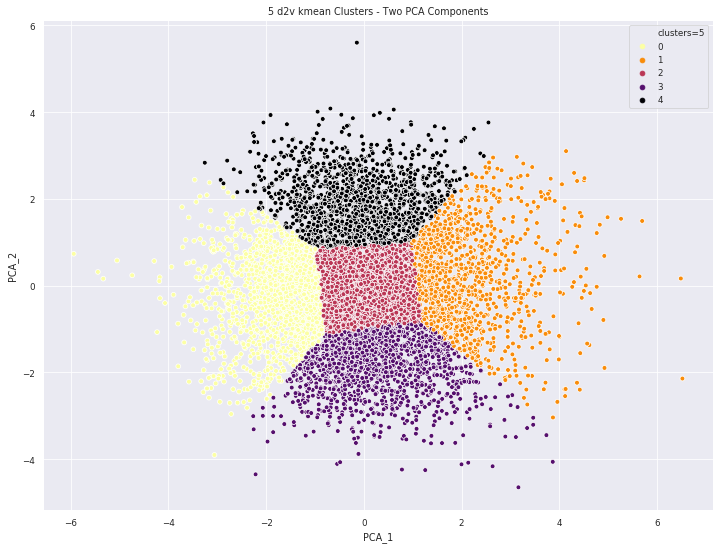


Avg Obs per cluster: 1523.4

Number of observations per cluster:
2    1896
0    1598
4    1522
3    1412
1    1189
dtype: int64
Time: 4.664540767669678 seconds.

Number of Clusters: 7

Silhouette Score 7 clusters: 0.2904988475665686




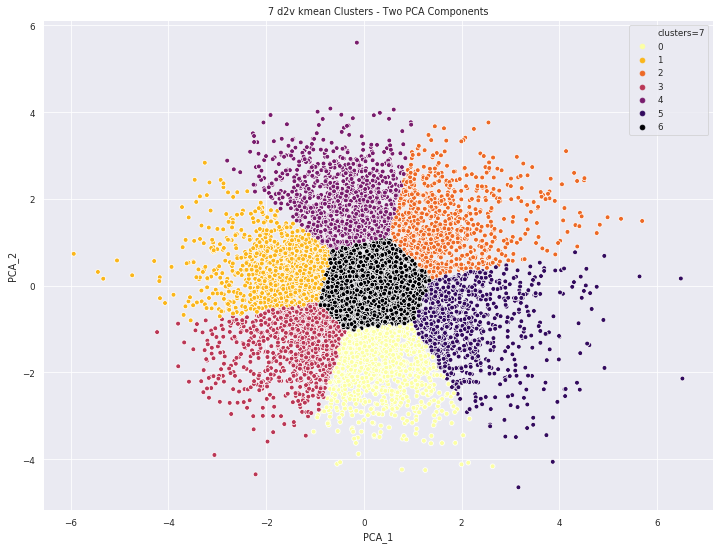


Avg Obs per cluster: 1088.142857142857

Number of observations per cluster:
6    1838
1    1147
4    1113
0     983
3     895
2     857
5     784
dtype: int64
Time: 2.7566051483154297 seconds.

Number of Clusters: 9

Silhouette Score 9 clusters: 0.13319725820042513




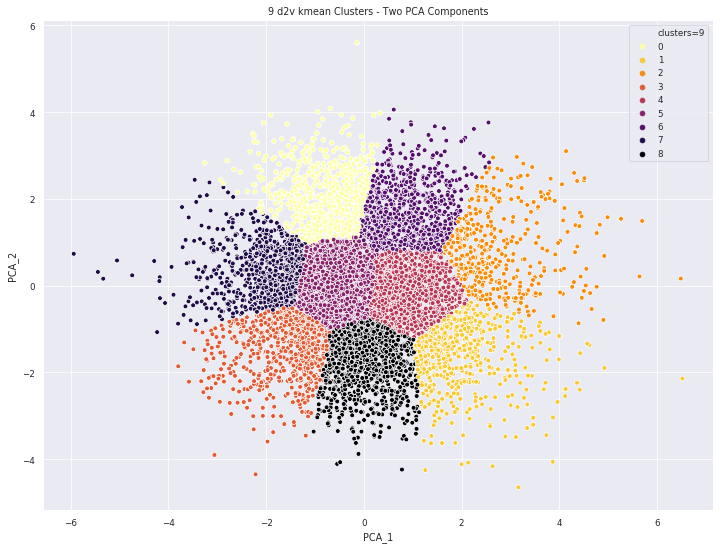


Avg Obs per cluster: 846.3333333333334

Number of observations per cluster:
5    1538
4    1107
8     988
6     859
0     778
7     732
3     658
1     537
2     420
dtype: int64
Time: 3.040466785430908 seconds.

Number of Clusters: 10

Silhouette Score 10 clusters: 0.06784929100411874




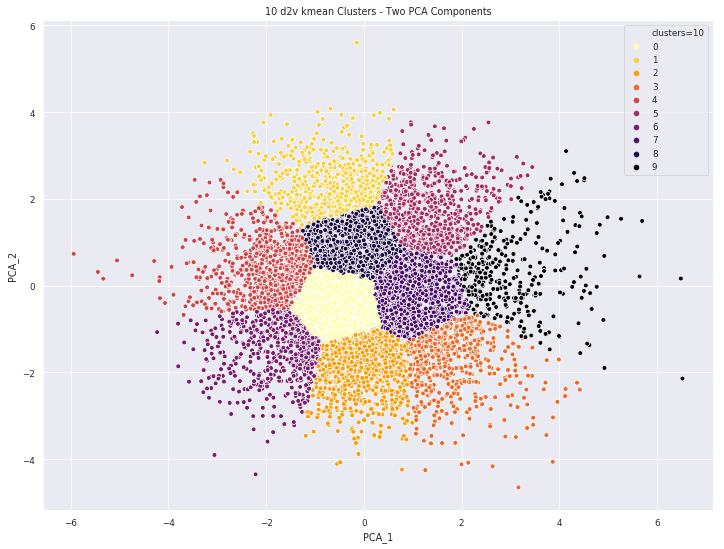


Avg Obs per cluster: 761.7

Number of observations per cluster:
0    1236
7    1037
8     941
2     847
4     840
5     686
1     631
6     554
3     505
9     340
dtype: int64
Time: 3.5668063163757324 seconds.

Number of Clusters: 11

Silhouette Score 11 clusters: 0.0004814066394579562




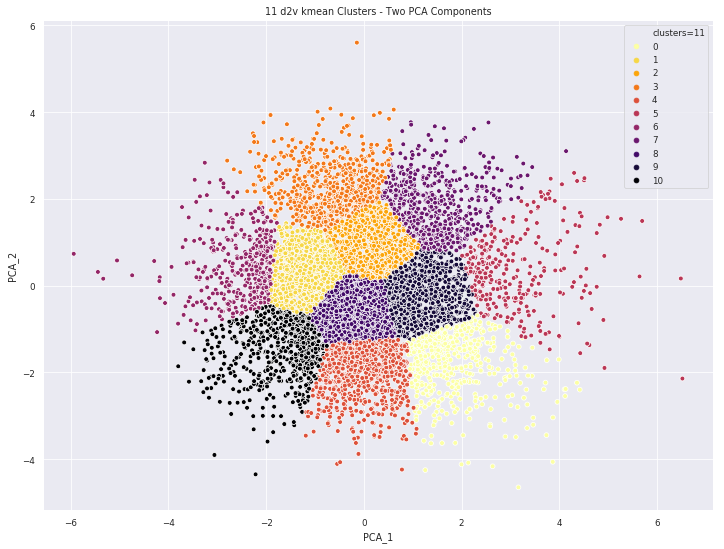


Avg Obs per cluster: 692.4545454545455

Number of observations per cluster:
8     1143
1      960
9      849
2      843
4      732
3      699
10     607
7      599
0      484
6      396
5      305
dtype: int64
Time: 3.2218098640441895 seconds.

Number of Clusters: 25

Silhouette Score 25 clusters: -0.2595161927303134




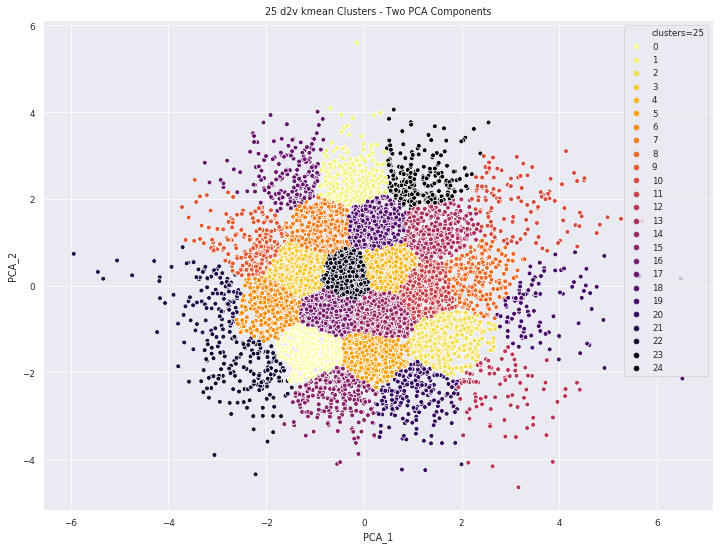


Avg Obs per cluster: 304.68

Number of observations per cluster:
14    538
23    531
16    530
3     477
5     425
18    418
11    396
4     386
7     372
2     357
13    339
0     330
dtype: int64
Time: 4.231027841567993 seconds.



In [99]:
sns.set_context('paper')
d2v_clusters = [5,7,9,10,11,25]
for i in d2v_clusters:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Y, d2v_clusters, metric='cosine'))
    print('\n')
    pca_d2vclusters['clusters='+str(i)] = d2v_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_d2vclusters,palette='inferno_r',legend='full')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_clusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

### Other features of Doc2Vec

- Doc2Vec has a method called .infer_vector(). Lets see we can use this as a classification method.
- We will once again extract the numerical vectors, calculate the cosign similarites with an infered vector.

In [438]:
raw_data.head()

filename                                           raw_text Professor  \
0   aurouxmcalc1  So let us start right away with stuff that we ...    Auroux   
1  aurouxmcalc11      to    So far we have learned about partial...    Auroux   
2   aurouxmcalc2  So , So, yesterday we learned about the questi...    Auroux   
3   aurouxmcalc5      to    So, so far, we have seen things abou...    Auroux   
4   demainedata1          . I am  . You can call me PROFESSOR. W...   Demaine   

    Subject                                               sdoc  
0  Calculus  (So, let, us, start, right, away, with, stuff,...  
1  Calculus  (    , to,    , So, far, we, have, learned, ab...  
2  Calculus  (So, ,, So, ,, yesterday, we, learned, about, ...  
3  Calculus  (    , to,    , So, ,, so, far, ,, we, have, s...  
4      Data  (        , ., I, am,  , ., You, can, call, me,...

In [439]:
X = np.array(raw_data['raw_text'])
y = np.array(raw_data[['filename','Professor','Subject']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [440]:
X_train.shape

(69,)

In [442]:
X_train[1][:50]

'PROFESSOR: Welcome to 6034. I do not know if I can'

In [69]:
d2v_vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])

In [70]:
#this is a function that uses 'infer vector'. 
#fuction:
# adds the new sentence to the corpus
#recalculates the similarity and returns the 5 most similar sentences.

def lecture_search (text):
    new_sentence = word_tokenize(text.lower())
    
    #infer vector position from the model
    new_vector = model.infer_vector(new_sentence)
    
    #transpose the DF to append the new vector and transpose again
    d2vt = d2v_vecs.T
    d2vt[len(d2vt.columns)] = new_vector
    d2vtt = d2vt.T
    
    #Calculate new similarity matrix and add sentences and index and columns
    new_sents = list(X_train)
    new_sents.insert(0,text)
    new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)
    
    #extend len of lectures to include no title for new sentence
    lectures = list(subsprofs[2].reset_index(drop=True))
    lectures.insert(0,'new_sentence')
    
    #calculate mean similarity, insert to DF, insert lectures
    #new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
    new_sim.insert(0, 'lecture', lectures)
    
    return new_sim[[text,'lecture']].sort_values(by=[text],ascending=False)[:10]

In [71]:
lecture_search('sometimes linear algebra is extremely cool')

sometimes linear algebra is extremely cool  \
sometimes linear algebra is extremely cool                                            1.000000   
the one go non 0 go one connect vector lie gutter                                     0.501946   
and want use hidden state decide access random ...                                    0.478475   
 say answer question error constellation academ...                                    0.473937   
 multiply matrix a inverse b inverse order  mul...                                    0.473212   
when probability a give b equal probability b g...                                    0.459554   
because remember o n mean statement mean limit ...                                    0.457270   
 matrix a right hand minus zero row minus minus...                                    0.455334   
so compute derivative 1 x^n  write x^-n right                                         0.454118   
and elimination go zero pivot problem bunch mul...                                    0.442551   

                                                               lecture  
sometimes linear algebra is extremely cool                new_sentence  
the one go non 0 go one connect vector lie gutter          winstonai16  
and want use hidden state decide access random ...        manningnlp10  
 say answer question error constellation academ...    leighton18csprob  
 multiply matrix a inverse b inverse order  mul...           strangLA4  
when probability a give b equal probability b g...   leighton19cprobcs  
because remember o n mean statement mean limit ...    leighton14dandcs  
 matrix a right hand minus zero row minus minus...           strangLA1  
so compute derivative 1 x^n  write x^-n right       jerisonmillercalc4  
and elimination go zero pivot problem bunch mul...         strangmeng3

In [72]:
orig_text = "and address original question dog cat world diet drink make people fat"
new_sent = word_tokenize(orig_text.lower())
new_sent

['and',
 'address',
 'original',
 'question',
 'dog',
 'cat',
 'world',
 'diet',
 'drink',
 'make',
 'people',
 'fat']

In [73]:
wvec = model.infer_vector(new_sent)

In [74]:
d2vt = d2v_vecs.T
d2vt[len(d2vt.columns)] = wvec
d2vtt = d2vt.T
d2vtt.head()

0         1         2         3         4         5         6   \
0 -0.000089  1.613576 -1.213172 -0.699590 -0.455341 -1.654266  1.328391   
1 -0.142554  0.530366 -0.050282 -0.019574 -1.094844 -0.665445  1.449891   
2  1.239875  0.653047  1.582765  0.276166  0.046460 -0.458217 -0.127665   
3  0.081314  2.499122  1.252915  0.293486  0.273326 -1.683249  0.904004   
4  1.039685  1.564360  1.051860 -0.763767  0.772274 -2.695213 -3.893208   

         7         8         9     ...           90        91        92  \
0  0.145195 -0.680698  1.620924    ...    -0.345252 -0.071085  0.005269   
1  0.333300  1.175720 -1.047934    ...     0.600445 -0.084197 -1.898219   
2  0.690694 -2.128486  2.117183    ...     1.292654 -0.703979 -1.323295   
3  0.152202  0.466658  0.410866    ...    -0.885424 -1.779712 -2.268085   
4 -0.893219  1.642717  2.256560    ...    -1.464969  0.720663  1.775017   

         93        94        95        96        97        98        99  
0 -0.412392 -0.420729  0.384282  0.186575  0.517352  1.761938 -0.541182  
1 -1.673319  0.955215  1.329180 -0.245165 -0.377990 -0.692338 -0.820201  
2  0.765877  1.967245  0.847940  0.831773  0.406738 -0.120499 -0.813294  
3 -0.877050  0.339623  3.547992 -0.966124  1.202199 -1.575344 -4.124265  
4 -0.244648 -0.614442  0.149077 -0.242392  1.168190  1.126175 -1.747790  

[5 rows x 100 columns]

In [75]:
new_sents = list(X_train)
new_sents.insert(0,orig_text)

In [76]:
new_sents

['and address original question dog cat world diet drink make people fat',
 'and non parametric estimation typically actually want parametrize large class function',
 'now discard node n heap simply decrement heap size',
 'so probabilistic argument assume hash function pretty good hash function',
 'then guess 2d peak great equal b great equal d c e.',
 'then  say  want y plus bx  go add noise epsilon away line',
 'at  plug x = y^2  y = y^2 2',
 'and analysis assumption form give carol place prize box 1 probability contestant choose box 1 1/3',
 'and neonatal right preference make surprising romantic reappearance later life',
 'and question line correspond parameter hat b hat  sure line far line',
 'therefore fit edge  convert tree pattern look like',
 'ok  go speak matrix r reduce row echelon form',
 'equal h prime k hash function choose plus mod m ordinary hash function',
 'and simple idea use let dot product decode hidden state encode hidden state',
 ' adaptive scheme assume algorith

In [77]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [78]:
print(d2vt.shape)

print(d2vt.shape)


(100, 7618)
(100, 7618)


In [79]:
d2vtt.shape

(7618, 100)

In [80]:
new_sents = list(X_train)

In [81]:
new_sents.insert(0,orig_text)

In [82]:
new_sents

['and address original question dog cat world diet drink make people fat',
 'and non parametric estimation typically actually want parametrize large class function',
 'now discard node n heap simply decrement heap size',
 'so probabilistic argument assume hash function pretty good hash function',
 'then guess 2d peak great equal b great equal d c e.',
 'then  say  want y plus bx  go add noise epsilon away line',
 'at  plug x = y^2  y = y^2 2',
 'and analysis assumption form give carol place prize box 1 probability contestant choose box 1 1/3',
 'and neonatal right preference make surprising romantic reappearance later life',
 'and question line correspond parameter hat b hat  sure line far line',
 'therefore fit edge  convert tree pattern look like',
 'ok  go speak matrix r reduce row echelon form',
 'equal h prime k hash function choose plus mod m ordinary hash function',
 'and simple idea use let dot product decode hidden state encode hidden state',
 ' adaptive scheme assume algorith

In [83]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [84]:
lectures = list(subsprofs[2].reset_index(drop=True))
lectures.insert(0,'new_sent')

In [85]:
new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
new_sim.insert(0, 'lecture', lectures)

In [86]:
new_sim[[orig_text,'lecture','mean_similarity']].sort_values(by=[orig_text],ascending=False)[:5]

and address original question dog cat world diet drink make people fat  \
and address original question dog cat world die...                                           1.000000                        
the one go non 0 go one connect vector lie gutter                                            0.501946                        
and want use hidden state decide access random ...                                           0.478475                        
 say answer question error constellation academ...                                           0.473937                        
 multiply matrix a inverse b inverse order  mul...                                           0.473212                        

                                                             lecture  \
and address original question dog cat world die...          new_sent   
the one go non 0 go one connect vector lie gutter        winstonai16   
and want use hidden state decide access random ...      manningnlp10   
 say answer question error constellation academ...  leighton18csprob   
 multiply matrix a inverse b inverse order  mul...         strangLA4   

                                                    mean_similarity  
and address original question dog cat world die...         0.127045  
the one go non 0 go one connect vector lie gutter          0.203106  
and want use hidden state decide access random ...         0.095639  
 say answer question error constellation academ...         0.164080  
 multiply matrix a inverse b inverse order  mul...         0.126099

In [91]:
end = time.time()
print('Notebook time: {} Minutes'.format((time.time()-glob_time1)/60))

Notebook time: 23.081870536009472 Minutes


In [ ]:
top_sents = new_sim.sort_values(by='mean_similarity',ascending=False)\
        [:10][['lecture', 'mean_similarity']]

In [ ]:
test_df = new_sim[[orig_text,'lecture']]
test_df.head()

In [ ]:
test_df.sort_values(by=orig_text,ascending=False)

In [ ]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [ ]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

In [ ]:
new_sim[:orig_text]

In [ ]:
top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]

In [ ]:
model.most_similar('so problem choice h prime k hash function work chain')

In [ ]:
len(new_sents)

In [ ]:

v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])